In [502]:
import numpy as np
import pandas as pd
import os
import warnings
import lightgbm as lgb
from tqdm import tqdm
import math
import seaborn as sns

from scipy.stats import gamma
import datetime as dt
from sklearn.model_selection import train_test_split
import sys 
sys.path.append('..')

from utils.demand_pkg import *
import matplotlib.pyplot as plt
from utils.algorithms import get_opt, get_EQ, get_end2end_iid, get_end2end, get_normal_basestock, get_gamma_basestock, get_normal_basestock2


In [501]:
df_vlt = pd.read_csv('../data/1320/vlt_2018_0708.csv', parse_dates=['create_tm','complete_dt','dt'])

In [370]:
df_vlt['create_tm_index'] = (df_vlt['create_tm']- dt.datetime.strptime('2016-01-01','%Y-%m-%d')).dt.days
df_vlt['complete_dt_index'] = (df_vlt['complete_dt']- dt.datetime.strptime('2016-01-01','%Y-%m-%d')).dt.days

In [371]:
df_vlt = df_vlt.dropna(how='any')
df_vlt = df_vlt.sort_values(['item_sku_id','int_org_num','create_tm_index','dt'], ascending=[True, True, True, True])

In [372]:
df_vlt['item_sku_id'] = df_vlt[['item_sku_id', 'int_org_num']].astype(str).apply(lambda x: '#'.join(x), axis=1)

In [379]:
df_vlt = df_vlt.drop_duplicates(['item_sku_id', 'create_tm_index'], keep='last')
df_vlt = df_vlt.reset_index(drop=True)
df_vlt.to_csv('../data/1320/vlt_0708_features.csv', index=False)

In [380]:
df_vlt.shape

(146698, 63)

In [531]:
df_use = pd.read_csv('../data/1320/inv.csv')
df_use['y'] = df_use.stockQuantity_since_2016.apply(lambda x: list(map(float, x.replace('[','').replace(']','').split(','))))
df_fill = df_use.y.apply(pd.Series)
df_fill_new = df_fill.rename(columns = lambda x : (dt.datetime(2016,1,1) + dt.timedelta(days=x)))
df_fill_new.insert(loc=0, column='item_sku_id', value=df_use['identity'])
df_st = df_fill_new.set_index('item_sku_id')
df_st.to_csv('../data/1320/stock.csv')

In [591]:
df_st = pd.read_csv('../data/1320/stock.csv', index_col=0)

In [595]:
df_st.columns = pd.to_datetime(df_st.columns)

In [597]:
df_vlt['initial_stock'] = df_vlt.apply(lambda x: df_st.loc[x['item_sku_id'], x['create_tm'].normalize() ] \
                                if x['item_sku_id'] in df_st.index else np.nan, axis=1)

In [559]:
df_vlt['VLT'] = (df_vlt['complete_dt'] - df_vlt['create_tm']) / timedelta (days=1)

In [571]:
df_vlt['review_period'] = df_vlt['create_tm'].diff().shift(-1)/ timedelta (days=1)

In [578]:
df_vlt.loc[df_vlt['review_period'] <=0, 'review_period']\
= (dt.datetime(2018,8,31) - df_vlt.loc[df_vlt['review_period'] <=0, 'create_tm'])/ timedelta (days=1)

In [616]:
df_vlt['next_complete_dt'] = df_vlt.groupby('item_sku_id').complete_dt.shift(-1).fillna(dt.datetime(2018,8,31))

In [644]:
df_vlt['demand_RV'] = df_vlt.apply(lambda x: sum(df_sl.loc[x['item_sku_id'], \
                                    x['create_tm'].date():x['next_complete_dt'].date()].values)\
                    if x['item_sku_id'] in df_sl.index else np.nan, axis=1)

In [652]:
df_vlt['demand_V'] = df_vlt.apply(lambda x: sum(df_sl.loc[x['item_sku_id'], \
                                    x['create_tm'].date():x['complete_dt'].date()].values)\
                    if x['item_sku_id'] in df_sl.index else np.nan, axis=1)

In [653]:
df_vlt['target_decision'] = df_vlt['demand_RV'] - df_vlt['initial_stock']
df_vlt['target_decision'].clip(0.0, inplace=True)

In [654]:
df_vlt['target_decision_nobc'] = df_vlt['demand_RV'] - df_vlt['demand_V'] \
                            - (df_vlt['initial_stock'] - df_vlt['demand_V']).clip(0.0)
df_vlt['target_decision_nobc'].clip(0.0, inplace=True)

In [659]:
df_vlt[df_vlt['item_sku_id']=='258214#6']

,item_sku_id,int_org_num,item_first_cate_cd,item_second_cate_cd,item_third_cate_cd,brand_code,create_day_of_week,create_tm,complete_dt,vlt_actual,...,complete_dt_index,create_tm_temp,initial_stock,VLT,review_period,next_complete_dt,demand_RV,target_decision,demand_V,target_decision_nobc
18,258214#6,6,1320,5019,5022,4537,2,2018-07-30 04:50:54,2018-08-06 16:24:26,7.481620,...,948,2018-07-30,130.0,7.481620,1.417975,2018-08-06 16:24:57,939.0,809.0,939.0,0.0
19,258214#6,6,1320,5019,5022,4537,3,2018-07-31 14:52:47,2018-08-06 16:24:57,6.064005,...,948,2018-07-31,0.0,6.064005,7.592269,2018-08-13 16:38:35,1810.0,1810.0,798.0,1012.0
20,258214#6,6,1320,5019,5022,4537,4,2018-08-08 05:05:39,2018-08-13 16:38:35,5.481204,...,955,2018-08-08,2726.0,5.481204,5.013519,2018-08-21 19:39:29,1966.0,0.0,864.0,0.0
21,258214#6,6,1320,5019,5022,4537,2,2018-08-13 05:25:07,2018-08-21 19:39:29,8.593310,...,963,2018-08-13,2957.0,8.593310,6.987188,2018-08-26 19:07:53,1741.0,0.0,1262.0,0.0
22,258214#6,6,1320,5019,5022,4537,2,2018-08-20 05:06:40,2018-08-26 19:07:53,6.584178,...,968,2018-08-20,1881.0,6.584178,10.787037,2018-08-31 00:00:00,1322.0,0.0,787.0,0.0


In [634]:
df_sl = pd.read_csv('../data/1320/rdc_sales_1320_replenishment_V1_filled_pp.csv',index_col=0)

In [635]:
df_sl.rename(columns=lambda x: (dt.datetime(2016,1,1) + dt.timedelta(days=int(x)-730)).date(), inplace=True)

In [420]:
get_rolling_mean(df_sl, [3, 7, 14, 30, 60, 140], path='../data/1320/')

window_3_mean
window_7_mean
window_14_mean
window_30_mean
window_60_mean
window_140_mean


In [421]:
get_rolling_quantile(df_sl, [90], [3, 7, 14, 30, 60, 140], path='../data/1320/')

window_3_quantile_90
window_7_quantile_90
window_14_quantile_90
window_30_quantile_90
window_60_quantile_90
window_140_quantile_90


In [241]:
quantile_list = [90]
quantile_window_list = [7,14,28,56,112]
mean_window_list = [3,7,14,28,56,112]
path2feature = '../data/demand_pkg'

In [242]:
quantile_feature, mean_feature = read_feature_data(quantile_list, quantile_window_list, mean_window_list, path2feature)

Reading  window_7_quantile_90
Reading  window_14_quantile_90
Reading  window_28_quantile_90
Reading  window_56_quantile_90
Reading  window_112_quantile_90
Reading  window_3_mean
Reading  window_7_mean
Reading  window_14_mean
Reading  window_28_mean
Reading  window_56_mean
Reading  window_112_mean


In [243]:
df = pd.read_csv('../data/demand_pkg/df_train_sales_filled.csv',index_col=0)

In [245]:
df.columns = pd.to_datetime(df.columns)

In [246]:
# how to call function
q = quantile_list[0]
is_far = 0
pred_len_list = [31, 14, 7, 3, 1]
pred_len = pred_len_list[0]
Model = 'M2Q'
# test_date = datetime.strptime('2018-03-01', '%Y-%m-%d')  

# X_train, y_train = prepare_training_data(df, 
#                                          q, 
#                                          is_far, 
#                                          pred_len, 
#                                          Model, 
#                                          test_date, 
#                                          mean_window_list, 
#                                          quantile_window_list, 
#                                          quantile_feature,
#                                          mean_feature,
#                                          is_train=True)
# X_train = np.round(X_train,4)
# y_train = np.round(y_train,4)

In [247]:
date1 = dt.datetime.strptime('2018-03-01','%Y-%m-%d')
date2 = date1 + pd.DateOffset(1)
today = df_vlt[(df_vlt['create_tm'] >= date1) & (df_vlt['create_tm'] < date2)]

In [339]:
test_date = df_vlt['create_tm'].dt.normalize().rename('train_date')

In [254]:
# test_date = datetime.strptime('2018-03-01', '%Y-%m-%d')  
time_back_num = 2
rolling_num = 5
rolling_span = 7
train_date = get_train_date(test_date, pred_len, is_far, rolling_num, rolling_span, time_back_num)

In [255]:
train_date

0       2017-12-16
1       2017-12-19
2       2018-01-06
3       2017-12-14
4       2017-12-14
5       2017-12-14
6       2017-12-16
7       2017-12-14
8       2017-12-14
9       2017-12-16
10      2017-12-16
11      2017-12-16
12      2017-12-14
13      2018-01-06
14      2017-12-14
15      2017-12-16
16      2017-12-14
17      2017-12-16
18      2017-12-14
19      2017-12-16
20      2017-12-16
21      2017-12-19
22      2017-12-19
23      2017-12-14
24      2017-12-16
25      2017-12-19
26      2017-12-12
27      2018-01-08
28      2017-12-12
29      2018-01-08
           ...    
63616   2017-12-19
63617   2017-12-19
63618   2018-01-01
63619   2018-01-01
63620   2018-01-13
63621   2018-01-13
63622   2018-01-13
63623   2018-01-04
63624   2018-01-04
63625   2018-01-04
63626   2018-01-04
63627   2018-01-12
63628   2018-01-12
63629   2018-01-12
63630   2018-01-12
63631   2018-01-11
63632   2018-01-12
63633   2018-01-12
63634   2018-01-11
63635   2018-01-12
63636   2018-01-12
63637   2018

In [98]:
df_key = pd.concat([df_vlt['item_sku_id'], train_date], axis=1)

In [23]:
df_value = quantile_feature.get('window_7_quantile_90', None)
df_value.columns.name = 'date'
df_value = df_value.stack()
df_value = df_value.to_frame('quantile_value')
quantile_value = pd.merge(df_key, df_value, how='left', left_on=['item_sku_id','train_date'], right_index=True)

In [24]:
quantile_value 

,item_sku_id,train_date,quantile_value
0,258214#3,2017-12-16,384.4
1,258214#3,2017-12-19,235.4
2,258214#3,2018-01-06,162.2
3,258214#4,2017-12-14,92.8
4,258214#5,2017-12-14,102.2
5,258214#9,2017-12-14,120.2
6,258214#9,2017-12-16,120.2
7,258214#316,2017-12-14,46.0
8,258214#772,2017-12-14,51.0
9,258217#5,2017-12-16,8.0


In [94]:
# df.columns.name = 'date'
# df_value2 = df.stack()
# df_value2 = df_value2.to_frame('summary')
# summary_value = pd.merge(df_key, df_value2, how='left', left_on=['item_sku_id','train_date'], right_index=True)
df_vlt['quantile_value'] = df_key[['item_sku_id', 'train_date']].\
                            apply(lambda x: mm.loc[x.item_sku_id, x.train_date] \
                            if x.item_sku_id in mm.index else np.nan, axis=1)
# df_key[['item_sku_id', 'train_date']].apply(tuple, axis=1).apply(lambda x: mm.loc[x[0],x[1]] if x[0] in mm.index else np.nan)

In [26]:
date_common = pd.date_range(start=train_date[0]-timedelta(days=7), periods=7) & df.columns
len_common = len(date_common)
date_diff = pd.date_range(start=train_date[0]-timedelta(days=(7+30)), periods=(7-len_common))

In [178]:
df_key['xdx'] = df_key.apply(lambda x: pd.date_range(start=x.train_date-timedelta(days=140), periods=140) & df.columns, axis=1)

In [181]:
df_key['len_common'] = df_key['xdx'].apply(len)
df_key['date_diff'] = df_key.apply(lambda x: \
    pd.date_range(start=x['train_date']-timedelta(days=(140+30)), periods=(140-x['len_common'])), axis=1 )

In [205]:
df_key.iloc[0,2]

DatetimeIndex(['2017-07-29', '2017-07-30', '2017-07-31', '2017-08-01',
               '2017-08-02', '2017-08-03', '2017-08-04', '2017-08-05',
               '2017-08-06', '2017-08-07',
               ...
               '2017-12-06', '2017-12-07', '2017-12-08', '2017-12-09',
               '2017-12-10', '2017-12-11', '2017-12-12', '2017-12-13',
               '2017-12-14', '2017-12-15'],
              dtype='datetime64[ns]', length=140, freq='D')

In [206]:
df.loc['258238#772', df_key.iloc[0,2]]

2017-07-29     3.0
2017-07-30     7.0
2017-07-31    12.0
2017-08-01    12.0
2017-08-02    17.0
2017-08-03    16.0
2017-08-04    23.0
2017-08-05    11.0
2017-08-06    12.0
2017-08-07     7.0
2017-08-08    26.0
2017-08-09    10.0
2017-08-10    12.0
2017-08-11    18.0
2017-08-12    22.0
2017-08-13    25.0
2017-08-14    25.0
2017-08-15    16.0
2017-08-16    10.0
2017-08-17    21.0
2017-08-18    13.0
2017-08-19    14.0
2017-08-20     9.0
2017-08-21    18.0
2017-08-22    11.0
2017-08-23     6.0
2017-08-24     3.0
2017-08-25    11.0
2017-08-26    10.0
2017-08-27    15.0
              ... 
2017-11-16    16.0
2017-11-17     0.0
2017-11-18    17.0
2017-11-19    15.0
2017-11-20    16.0
2017-11-21    16.0
2017-11-22    19.0
2017-11-23    14.0
2017-11-24    16.0
2017-11-25     3.0
2017-11-26     8.0
2017-11-27    23.0
2017-11-28    18.0
2017-11-29    17.0
2017-11-30    16.0
2017-12-01    18.0
2017-12-02    15.0
2017-12-03    14.0
2017-12-04    13.0
2017-12-05    12.0
2017-12-06    12.0
2017-12-07  

In [220]:
xx = df_key.apply(lambda x: pd.Series(df.loc[x.item_sku_id, x['xdx'].append(x['date_diff']) ].values \
                            if x.item_sku_id in df.index else [np.nan]*140  # can be faster
                            ), axis=1)

In [351]:
X_test = prepare_training_data(df, q, 
                             is_far, 
                             pred_len, 
                             Model, 
                             test_date, 
                             mean_window_list, 
                             quantile_window_list, 
                             quantile_feature,
                             mean_feature,
                             df_vlt['item_sku_id'],
                             is_train=False)

summary s1 begin.


/Users/schemmy/anaconda3/envs/tf/lib/python3.6/site-packages/numpy/lib/function_base.py:4033: RuntimeWarning: All-NaN slice encountered
  r = func(a, **kwargs)


summary s2 begin.


In [356]:
X_test

,q_7,q_14,q_28,q_56,q_112,mean_3,mean_7,mean_14,mean_28,mean_56,...,first_has_sales_day_in_last_60,has_sales_days_in_last_30,last_has_sales_day_in_last_30,first_has_sales_day_in_last_30,has_sales_days_in_last_14,last_has_sales_day_in_last_14,first_has_sales_day_in_last_14,has_sales_days_in_last_7,last_has_sales_day_in_last_7,first_has_sales_day_in_last_7
0,267.2,249.7,275.5,294.0,266.7,239.333333,169.142857,151.357143,138.392857,171.464286,...,60.0,30,1.0,30.0,14,1.0,14.0,7,1.0,7.0
1,267.2,249.7,275.5,290.5,266.7,169.000000,205.857143,170.785714,154.035714,166.660714,...,60.0,30,1.0,30.0,14,1.0,14.0,7,1.0,7.0
2,193.8,206.2,249.3,249.5,254.9,149.333333,151.571429,167.785714,182.821429,152.250000,...,60.0,30,1.0,30.0,14,1.0,14.0,7,1.0,7.0
3,28.4,28.7,29.6,58.0,53.0,23.000000,22.285714,21.285714,21.607143,32.857143,...,60.0,29,1.0,30.0,14,1.0,14.0,7,1.0,7.0
4,45.8,42.0,45.6,80.0,75.7,29.000000,29.428571,25.428571,25.607143,42.642857,...,60.0,30,1.0,30.0,14,1.0,14.0,7,1.0,7.0
5,60.8,37.4,67.7,75.5,70.5,32.333333,39.428571,29.500000,30.178571,40.750000,...,60.0,30,1.0,30.0,14,1.0,14.0,7,1.0,7.0
6,51.4,59.2,75.4,75.5,70.6,48.000000,37.142857,33.785714,33.607143,41.821429,...,60.0,30,1.0,30.0,14,1.0,14.0,7,1.0,7.0
7,17.4,16.7,18.6,27.5,29.8,13.000000,11.142857,9.785714,9.142857,15.589286,...,60.0,27,1.0,30.0,13,1.0,14.0,6,1.0,7.0
8,35.8,34.6,39.7,53.0,45.9,26.666667,29.857143,29.214286,25.821429,32.375000,...,60.0,30,1.0,30.0,14,1.0,14.0,7,1.0,7.0
9,3.0,3.7,5.6,8.0,8.0,3.000000,2.714286,2.714286,2.535714,3.982143,...,60.0,23,1.0,30.0,14,1.0,14.0,7,1.0,7.0


In [345]:
X = pd.DataFrame()
quantile = 90
train_date = test_date
sku_dc_pair =df_vlt['item_sku_id']
for window in quantile_window_list:
    quantile_column = 'window_{window}_quantile_{quantile}'.format(window=window, quantile=quantile) #TODO: change this hard coded thing
    quantile_column_name = 'q_{window}'.format(window=window)
    X[quantile_column_name] = get_quantile_value(quantile, window, quantile_feature, sku_dc_pair, train_date)

for window in mean_window_list:
    mean_column = 'window_{window}_mean'.format(window=window)
    mean_column_name = 'mean_{window}'.format(window=window)
    X[mean_column_name] = get_mean_value(window, mean_feature, sku_dc_pair, train_date)    

In [354]:
X

,q_7,q_14,q_28,q_56,q_112,mean_3,mean_7,mean_14,mean_28,mean_56,mean_112
0,267.2,249.7,275.5,294.0,266.7,239.333333,169.142857,151.357143,138.392857,171.464286,167.392857
1,267.2,249.7,275.5,290.5,266.7,169.000000,205.857143,170.785714,154.035714,166.660714,167.741071
2,193.8,206.2,249.3,249.5,254.9,149.333333,151.571429,167.785714,182.821429,152.250000,165.080357
3,28.4,28.7,29.6,58.0,53.0,23.000000,22.285714,21.285714,21.607143,32.857143,32.383929
4,45.8,42.0,45.6,80.0,75.7,29.000000,29.428571,25.428571,25.607143,42.642857,40.446429
5,60.8,37.4,67.7,75.5,70.5,32.333333,39.428571,29.500000,30.178571,40.750000,39.446429
6,51.4,59.2,75.4,75.5,70.6,48.000000,37.142857,33.785714,33.607143,41.821429,40.053571
7,17.4,16.7,18.6,27.5,29.8,13.000000,11.142857,9.785714,9.142857,15.589286,17.000000
8,35.8,34.6,39.7,53.0,45.9,26.666667,29.857143,29.214286,25.821429,32.375000,29.169643
9,3.0,3.7,5.6,8.0,8.0,3.000000,2.714286,2.714286,2.535714,3.982143,3.642857


In [329]:
X = pd.DataFrame()
window_list = [[3, 7, 14, 30, 60, 140], [7, 14, 30, 60, 140]] 
print('summary s1 begin.')
for i in range(len(window_list[0])-1, -1, -1):
    window = window_list[0][i]
    if i == len(window_list[0])-1:
        tmp = get_back_timespan(df, sku_dc_pair, train_date, window, window)
        tmp_copy = tmp.copy()
    else:
        tmp = tmp.iloc[:, -window:]
    X['diff_%s_mean_2' % window] = tmp.diff(axis=1).mean(axis=1)
    X['mean_%s_decay_2' % window] = (tmp * np.power(0.9, np.arange(window)[::-1])).sum(axis=1)
    X['median_%s_2' % window] = tmp.median(axis=1).values # median is exactly 50th quantile
    X['min_%s_2' % window] = tmp.min(axis=1)
    X['max_%s_2' % window] = tmp.max(axis=1)
    X['std_%s_2' % window] = tmp.std(axis=1)

print('summary s2 begin.')
for i in range(len(window_list[1])-1, -1, -1):
    window = window_list[1][i]
    if i == len(window_list[1])-1:
        if window ==  window_list[0][-1]:
             tmp = tmp_copy.copy()
        else:
            tmp = get_back_timespan(df, sku_dc_pair, train_date, window, window)
    else:
        tmp = tmp.iloc[:, -window:]
    X['has_sales_days_in_last_%s' % window] = (tmp > 0).sum(axis=1)
    X['last_has_sales_day_in_last_%s' % window] = window - ((tmp > 0) * np.arange(window)).max(axis=1)
    X['first_has_sales_day_in_last_%s' % window] = ((tmp > 0) * np.arange(window, 0, -1)).max(axis=1)


summary s1 begin.
(63646, 140)


/Users/schemmy/anaconda3/envs/tf/lib/python3.6/site-packages/numpy/lib/function_base.py:4033: RuntimeWarning: All-NaN slice encountered
  r = func(a, **kwargs)


(63646, 60)
(63646, 30)
(63646, 14)
(63646, 7)
(63646, 3)
summary s2 begin.
(63646, 140)
(63646, 60)
(63646, 30)
(63646, 14)
(63646, 7)


In [334]:
X

,diff_140_mean_2,mean_140_decay_2,median_140_2,min_140_2,max_140_2,std_140_2,diff_60_mean_2,mean_60_decay_2,median_60_2,min_60_2,...,first_has_sales_day_in_last_60,has_sales_days_in_last_30,last_has_sales_day_in_last_30,first_has_sales_day_in_last_30,has_sales_days_in_last_14,last_has_sales_day_in_last_14,first_has_sales_day_in_last_14,has_sales_days_in_last_7,last_has_sales_day_in_last_7,first_has_sales_day_in_last_7
0,0.985612,1670.064931,145.0,14.0,670.0,101.419016,2.203390,1667.747040,149.0,14.0,...,60.0,30,1.0,30.0,14,1.0,14.0,7,1.0,7.0
1,0.582734,1681.017235,146.5,14.0,670.0,100.928815,1.423729,1678.692528,153.0,14.0,...,60.0,30,1.0,30.0,14,1.0,14.0,7,1.0,7.0
2,0.381295,1711.788001,155.0,14.0,607.0,87.225373,-2.254237,1707.915430,153.0,14.0,...,60.0,30,1.0,30.0,14,1.0,14.0,7,1.0,7.0
3,0.014388,239.738182,27.0,0.0,127.0,21.553179,0.271186,239.335038,28.0,0.0,...,60.0,29,1.0,30.0,14,1.0,14.0,7,1.0,7.0
4,0.251799,295.523053,30.5,3.0,184.0,30.315606,0.389831,294.942851,32.0,3.0,...,60.0,30,1.0,30.0,14,1.0,14.0,7,1.0,7.0
5,0.187050,338.211847,31.0,1.0,230.0,29.741237,0.135593,337.665469,32.5,1.0,...,60.0,30,1.0,30.0,14,1.0,14.0,7,1.0,7.0
6,0.143885,375.251582,31.0,1.0,230.0,29.708989,0.288136,374.711632,35.5,1.0,...,60.0,30,1.0,30.0,14,1.0,14.0,7,1.0,7.0
7,0.000000,109.501760,14.0,0.0,83.0,14.332670,0.118644,109.255525,13.5,0.0,...,60.0,27,1.0,30.0,13,1.0,14.0,6,1.0,7.0
8,0.122302,294.199507,26.5,1.0,126.0,21.162296,0.033898,293.770663,28.0,3.0,...,60.0,30,1.0,30.0,14,1.0,14.0,7,1.0,7.0
9,-0.007194,28.879427,3.0,0.0,21.0,3.436728,-0.016949,28.811326,3.0,0.0,...,60.0,23,1.0,30.0,14,1.0,14.0,7,1.0,7.0


In [310]:
tmp

,0,1,2
0,175.0,293.0,250.0
1,154.0,142.0,211.0
2,195.0,131.0,122.0
3,18.0,22.0,29.0
4,14.0,26.0,47.0
5,23.0,38.0,36.0
6,36.0,67.0,41.0
7,9.0,14.0,16.0
8,26.0,27.0,27.0
9,3.0,3.0,3.0


In [306]:
tmp

,0,1,2,3,4,5,6
0,83.0,83.0,84.0,216.0,175.0,293.0,250.0
1,216.0,175.0,293.0,250.0,154.0,142.0,211.0
2,129.0,109.0,182.0,193.0,195.0,131.0,122.0
3,28.0,20.0,28.0,11.0,18.0,22.0,29.0
4,45.0,25.0,21.0,28.0,14.0,26.0,47.0
5,95.0,29.0,28.0,27.0,23.0,38.0,36.0
6,28.0,27.0,23.0,38.0,36.0,67.0,41.0
7,17.0,18.0,0.0,4.0,9.0,14.0,16.0
8,46.0,29.0,28.0,26.0,26.0,27.0,27.0
9,3.0,2.0,3.0,2.0,3.0,3.0,3.0


In [325]:
df_key = pd.concat([sku_dc_pair, train_date], axis=1)
df_key['date_common'] = df_key.apply(lambda x: \
            pd.date_range(start=x['train_date']-timedelta(days=140), periods=140), axis=1)

In [326]:
df_key.apply(lambda x: pd.Series(df.loc[x.item_sku_id, x['date_common'] ].values \
                            if x.item_sku_id in df.index else [np.nan]*140 
                            ), axis=1)

,0,1,2,3,4,5,6,7,8,9,...,130,131,132,133,134,135,136,137,138,139
0,113.0,97.0,74.0,130.0,129.0,252.0,151.0,145.0,114.0,119.0,...,139.0,249.0,167.0,83.0,83.0,84.0,216.0,175.0,293.0,250.0
1,130.0,129.0,252.0,151.0,145.0,114.0,119.0,670.0,187.0,132.0,...,83.0,83.0,84.0,216.0,175.0,293.0,250.0,154.0,142.0,211.0
2,69.0,79.0,83.0,130.0,114.0,110.0,129.0,121.0,140.0,207.0,...,176.0,163.0,187.0,129.0,109.0,182.0,193.0,195.0,131.0,122.0
3,27.0,12.0,27.0,14.0,15.0,15.0,9.0,46.0,41.0,16.0,...,22.0,21.0,23.0,28.0,20.0,28.0,11.0,18.0,22.0,29.0
4,12.0,24.0,19.0,20.0,23.0,16.0,23.0,57.0,25.0,27.0,...,16.0,21.0,35.0,45.0,25.0,21.0,28.0,14.0,26.0,47.0
5,10.0,27.0,21.0,36.0,29.0,24.0,20.0,64.0,28.0,41.0,...,13.0,23.0,23.0,95.0,29.0,28.0,27.0,23.0,38.0,36.0
6,21.0,36.0,29.0,24.0,20.0,64.0,28.0,41.0,16.0,12.0,...,23.0,95.0,29.0,28.0,27.0,23.0,38.0,36.0,67.0,41.0
7,16.0,11.0,13.0,7.0,11.0,6.0,17.0,29.0,10.0,11.0,...,11.0,11.0,3.0,17.0,18.0,0.0,4.0,9.0,14.0,16.0
8,10.0,12.0,11.0,12.0,14.0,14.0,28.0,53.0,27.0,17.0,...,27.0,37.0,29.0,46.0,29.0,28.0,26.0,26.0,27.0,27.0
9,4.0,1.0,1.0,0.0,1.0,2.0,14.0,2.0,8.0,6.0,...,2.0,5.0,3.0,3.0,2.0,3.0,2.0,3.0,3.0,3.0


In [485]:
X = pd.concat([df_vlt_fea, X_test], axis=1).astype(np.float32)

In [486]:
X = X.fillna(0)
labels = X[['first_has_sales_day_in_last_60']].values
X = X.values

In [2]:
import tensorflow as tf

input_dim = X.shape[1]
n_hidden = [100,10]
output_dim = 1
quantile = 0.9

tf.reset_default_graph()

x = tf.placeholder(tf.float32, shape=[None, input_dim])
y = tf.placeholder(tf.float32, shape=[None, 1])

W_1 = tf.Variable(tf.random_uniform([input_dim,n_hidden[0]]))
b_1 = tf.Variable(tf.zeros([1]))
layer_1 = tf.add(tf.matmul(x, W_1), b_1)
layer_1 = tf.nn.relu(layer_1)

W_2 = tf.Variable(tf.random_uniform([n_hidden[0],n_hidden[1]]))
b_2 = tf.Variable(tf.zeros([n_hidden[1]]))
layer_2 = tf.add(tf.matmul(layer_1,W_2), b_2)
layer_2 = tf.nn.relu(layer_2)

W_O = tf.Variable(tf.random_uniform([n_hidden[1],1]))
b_O = tf.Variable(tf.zeros([1]))
output = tf.add(tf.matmul(layer_2,W_O), b_O)
error = output - y

loss = tf.reduce_mean(tf.square(tf.maximum(quantile*error, (quantile-1)*error)) )

train_step = tf.train.AdamOptimizer().minimize(loss)

epochs = 10
batch_size = 64
init = tf.global_variables_initializer()

with tf.Session() as sess:
    sess.run(init)
    for epoch in range(epochs):
        # Split data to batches
        for idx in range(0, X.shape[0], batch_size):
            batch_data = X[idx : min(idx + batch_size, X.shape[0]),:]
            batch_labels = labels[idx : min(idx + batch_size, labels.shape[0]),:]
            feed_dict = {x: batch_data, y: batch_labels}
            _, c_loss = sess.run([train_step, loss], feed_dict)
            print(c_loss)

In [463]:
batch_labels[0][0].dtype

dtype('float64')

In [ ]:
df_sales = pd.read_csv('../data/1320/rdc_sales_1320_replenishment_V1_filled_pp.csv')

In [613]:
o0 = pd.read_csv('../data/1320_feature/features_v12.csv', parse_dates=['create_tm','complete_dt','dt'])

/Users/schemmy/anaconda3/envs/tf/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2785: DtypeWarning: Columns (140) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [537]:
o0['sales_R'] = o0['mean_140_decay_2'] * o0['review_period']
o0['sales_VLT'] = o0['mean_140_decay_2']*o0['vendor_vlt_mean']
o0['sales_std'] = np.sqrt(o0['review_period']+o0['vendor_vlt_mean'])*o0['std_140_2']

In [614]:
o0.columns[60:]

Index(['vendor_amount_max', 'vendor_amount_mean', 'actual_pur_qtty',
       'create_tm_index', 'complete_dt_index', 'q_7', 'q_14', 'q_28', 'q_56',
       'q_112', 'mean_3', 'mean_7', 'mean_14', 'mean_28', 'mean_56',
       'mean_112', 'diff_140_mean', 'mean_140_decay', 'median_140', 'min_140',
       'max_140', 'std_140', 'diff_60_mean', 'mean_60_decay', 'median_60',
       'min_60', 'max_60', 'std_60', 'diff_30_mean', 'mean_30_decay',
       'median_30', 'min_30', 'max_30', 'std_30', 'diff_14_mean',
       'mean_14_decay', 'median_14', 'min_14', 'max_14', 'std_14',
       'diff_7_mean', 'mean_7_decay', 'median_7', 'min_7', 'max_7', 'std_7',
       'diff_3_mean', 'mean_3_decay', 'median_3', 'min_3', 'max_3', 'std_3',
       'has_sales_days_in_last_140', 'last_has_sales_day_in_last_140',
       'first_has_sales_day_in_last_140', 'has_sales_days_in_last_60',
       'last_has_sales_day_in_last_60', 'first_has_sales_day_in_last_60',
       'has_sales_days_in_last_30', 'last_has_sales_day_i

In [417]:
o0 = o0.drop(columns='d_vlt')

In [615]:
IDX = ['item_sku_id']

CAT_FEA = [
#     'item_first_cate_cd', 'item_second_cate_cd', 
    'item_third_cate_cd', 
    'int_org_num', 'brand_code', 
    'create_day_of_week'
    ]

VLT_FEA = [
    'uprc', 'contract_stk_prc', 'wt', 'width', 'height', 'calc_volume', 'len',
    'vlt_count', 'vlt_sum', 'vlt_min', 'vlt_max', 'vlt_mean', 'vlt_std',
    'qtty_sum', 'qtty_min', 'qtty_max', 'qtty_mean', 'qtty_std', 
    'amount_sum', 'amount_min', 'amount_max', 'amount_mean', 'amount_std', 
    'vlt_count_6mo', 'vlt_sum_6mo', 'vlt_min_6mo', 'vlt_max_6mo', 'vlt_mean_6mo', 'vlt_std_6mo',
    'vendor_vlt_count', 'vendor_vlt_sum', 'vendor_vlt_min', 'vendor_vlt_max', 'vendor_vlt_mean', 'vendor_vlt_std', 
    'vendor_vlt_count_6mo', 'vendor_vlt_sum_6mo', 'vendor_vlt_min_6mo', 
    'vendor_vlt_max_6mo', 'vendor_vlt_mean_6mo', 'vendor_vlt_std_6mo', 
    'vendor_qtty_sum', 'vendor_qtty_min', 'vendor_qtty_max', 
    'vendor_qtty_mean', 'vendor_qtty_std', 'vendor_amount_sum',
    'vendor_amount_min', 'vendor_amount_max', 'vendor_amount_mean']

SF_FEA = ['q_7', 'q_14', 'q_28', 'q_56',
       'q_112', 'mean_3', 'mean_7', 'mean_14', 'mean_28', 'mean_56',
       'mean_112', 'diff_140_mean', 'mean_140_decay', 'median_140', 'min_140',
       'max_140', 'std_140', 'diff_60_mean', 'mean_60_decay', 'median_60',
       'min_60', 'max_60', 'std_60', 'diff_30_mean', 'mean_30_decay',
       'median_30', 'min_30', 'max_30', 'std_30', 'diff_14_mean',
       'mean_14_decay', 'median_14', 'min_14', 'max_14', 'std_14',
       'diff_7_mean', 'mean_7_decay', 'median_7', 'min_7', 'max_7', 'std_7',
       'diff_3_mean', 'mean_3_decay', 'median_3', 'min_3', 'max_3', 'std_3',
       'has_sales_days_in_last_140', 'last_has_sales_day_in_last_140',
       'first_has_sales_day_in_last_140', 'has_sales_days_in_last_60',
       'last_has_sales_day_in_last_60', 'first_has_sales_day_in_last_60',
       'has_sales_days_in_last_30', 'last_has_sales_day_in_last_30',
       'first_has_sales_day_in_last_30', 'has_sales_days_in_last_14',
       'last_has_sales_day_in_last_14', 'first_has_sales_day_in_last_14',
       'has_sales_days_in_last_7', 'last_has_sales_day_in_last_7',
       'first_has_sales_day_in_last_7']
   
MORE_FEA =['initial_stock', 'review_period', 'normal', 'gamma', 'eq']
    
LABEL = ['target_decision']    

# o0[VLT_CAT_FEA_COLS] = o0[VLT_CAT_FEA_COLS].astype('category')

# o1 = o0[VLT_CAT_FEA_COLS + VLT_NUM_FEA_COLS]

# o1 = pd.concat([df_vlt_fea, pd.get_dummies(df_vlt_fea[VLT_CAT_FEA_COLS])], axis=1)
# o2.drop(VLT_CAT_FEA_COLS, axis=1, inplace=True)

In [616]:
o1 = o0[o0.isnull().sum(axis=1) == 0]

In [617]:
o1.insert(1, 'sku_id', o1['item_sku_id'])

In [618]:
o1.loc[:,'sku_id'] = o1['item_sku_id'].apply(lambda x: x.split('#')[0])

In [619]:
sku_set = o1.sku_id.unique()
sku_train, sku_test = train_test_split(sku_set, random_state=3, train_size=0.9, test_size=0.1)

In [620]:
df_train = o1[o1['sku_id'].isin(sku_train)]
df_test = o1[o1['sku_id'].isin(sku_test)]
len(df_train), len(df_test)

(115326, 12811)

In [621]:
feature_list = CAT_FEA + VLT_FEA + SF_FEA + MORE_FEA
X_train = df_train[IDX + CAT_FEA + VLT_FEA + SF_FEA + MORE_FEA]
y_train = df_train[LABEL]

X_test = df_test[IDX + CAT_FEA + VLT_FEA + SF_FEA + MORE_FEA]
y_test = df_test[LABEL]

In [622]:
datanum = len(o1)
old_train = o1.loc[0:int(datanum*0.95)]
old_test = o1.loc[int(datanum*0.95):]

print( len(old_train['item_sku_id'].unique()),len(old_test['item_sku_id'].unique()))
print(len(old_train['sku_id'].unique()),len(old_test['sku_id'].unique()))
print(old_train.mean_3.mean(),old_test.mean_3.mean())

30706 2176
5384 445
32.57286694980462 15.338067738411112


In [623]:
print(X_train.mean_3.mean(), X_test.mean_3.mean())

31.904589309146818 29.97176905263706


In [636]:
gbm = lgb.LGBMRegressor(alpha=0.9, objective='quantile', max_depth = -10, num_leaves=31, learning_rate=0.05, 
                        n_estimators=200, 
                        subsample=0.7,
                        silent=1,
                        seed=0 )

gbm.fit(X_train.iloc[:,1:], y_train['target_decision'], eval_set=(X_test.iloc[:,1:], y_test['target_decision'].tolist()));

[1]	valid_0's l2: 177130
[2]	valid_0's l2: 166119
[3]	valid_0's l2: 157491
[4]	valid_0's l2: 148762
[5]	valid_0's l2: 141883
[6]	valid_0's l2: 135267
[7]	valid_0's l2: 128382
[8]	valid_0's l2: 121917
[9]	valid_0's l2: 116624
[10]	valid_0's l2: 110819
[11]	valid_0's l2: 106838
[12]	valid_0's l2: 104665
[13]	valid_0's l2: 101718
[14]	valid_0's l2: 98881.5
[15]	valid_0's l2: 97317.8
[16]	valid_0's l2: 95061.4
[17]	valid_0's l2: 93557.1
[18]	valid_0's l2: 92702.6
[19]	valid_0's l2: 92129.2
[20]	valid_0's l2: 91581.9
[21]	valid_0's l2: 89688.8
[22]	valid_0's l2: 89841.8
[23]	valid_0's l2: 90036.5
[24]	valid_0's l2: 88947.6
[25]	valid_0's l2: 89531.4
[26]	valid_0's l2: 89869.5
[27]	valid_0's l2: 90701.8
[28]	valid_0's l2: 90672.1
[29]	valid_0's l2: 90997.6
[30]	valid_0's l2: 90996.3
[31]	valid_0's l2: 91700.1
[32]	valid_0's l2: 91895.1
[33]	valid_0's l2: 92468.2
[34]	valid_0's l2: 92049.8
[35]	valid_0's l2: 92376.4
[36]	valid_0's l2: 93050.5
[37]	valid_0's l2: 93314.6
[38]	valid_0's l2: 9384

In [637]:

def get_opt(df_opt, inv, t, sku_dc):
    opt = df_opt.iloc[t]['overall_opt_order']
    #opt = df['overall_opt_order'].iloc[t] 
#     opt = df['overall_opt_order'].iloc[t] 
    return opt

def get_EQ(record, inv, t, renew_period, PERCENT=90):
    sales = record[0:t]
    EQ_series = [np.sum(sales[i:i+renew_period]) for i in range(len(sales)-renew_period)]
    EQ_value = np.percentile(EQ_series, PERCENT)
    action = np.max([EQ_value - inv, 0])
    return int(action)

def get_gamma_basestock(record, inv, t, renew_period, PERCENT=0.9):
    sales = record[0:t]
    mean = np.mean(sales)
    var = np.var(sales)
    theta = var/(mean+0.0000001)
    k = mean/(theta+0.0000001)
    k_sum = renew_period*k
    gamma_stock = gamma.ppf(PERCENT, a=k_sum, scale = theta)
    if(np.isnan(gamma_stock)):
        return 0
    else:
        action = np.max([int(gamma_stock)-inv, 0])
    return action
    
    
def get_end2end_iid(gbm, x, inv):
    feature = x[['vlt_mean_season', 'vlt_variance_season', 
               'vendor_vlt_mean', 'vendor_vlt_std', 'renew_period', 'initial_stock', 'mkt_prc', 'ave_3d_sale_near', 'ave_7d_sale_near',
               'ave_14d_sale_near', 'ave_28d_sale_near', 'ave_56d_sale_near', 'ave_3d_sale_far', 'ave_7d_sale_far', 'ave_14d_sale_far', 'ave_28d_sale_far',
               'ave_56d_sale_far', 'sales_14d_std']]
    feature['initial_stock'] = inv 
    feature = pd.DataFrame(feature, dtype='float').T
    action = np.max([gbm.predict(feature), 0])
    return int(action)

def get_end2end(gbm, x, inv, order_normal, order_gamma, order_eq, renew_period, feature_list):

#     x['renew_period'] = renew_period
#     x['sales_R'] = x['mean_140_decay_2']*renew_period
#     x['sales_VLT'] = x['mean_140_decay_2']*x['vendor_vlt_mean']
#     x['sales_std'] = np.sqrt(renew_period+x['vendor_vlt_mean'])*x['std_140_2']
#     x['normal'] = order_normal
#     x['gamma'] = order_gamma
#     x['eq'] = order_eq
    
    test_x = x[feature_list]
    xx = pd.DataFrame(test_x, dtype='float').T
    #action = np.max([gbm.predict(feature, categorical_feature=[0,1,2,3,4]), 0])
    action = np.max([gbm.predict(xx), 0])
    return int(action)

def get_normal_basestock(inv, sales_mean, sales_std, renew_period, VLT_mean, VLT_std, Z90 = 1.2816):
    VLT_std = 0
    action = np.max([0, sales_mean*(renew_period+VLT_mean)+
                     Z90*np.sqrt((renew_period+VLT_mean)*sales_std**2
                                 +sales_std**2*VLT_std)-inv])
    return int(action)

def get_normal_basestock2(record, inv, t, renew_period, VLT_mean, VLT_std, Z90 = 1.2816):
    sales = record[0:t]
    sales_mean = np.mean(sales)
    sales_std = np.std(sales)
    VLT_std = 0
    action = np.max([0, sales_mean*(renew_period+VLT_mean)+
                     Z90*np.sqrt((renew_period+VLT_mean)*sales_std**2
                                 +sales_std**2*VLT_std)-inv])
    return int(action)


In [638]:
def countOccurrences(arr, x):
    res = 0
    for i in range(len(arr)):
        if x == arr[i]:
            res += 1
    return res


def num_neg_element(data_list):
    counter = 0
    for i in data_list:
        if i <= 0:
            counter+=1
    return counter


def seqtest(sku_dc, START_DAY, inv0, df, gbm_dq, end_of_horizon, arrive_time, order_time, demand, feature_list, OPTION):
    inv = inv0
    h = 1
    b = 9
    history_inv = []
    order_list = []
    h_cost_list = []
    b_cost_list = []
    cost_list = []
    #print('Initial Inventory:', inv0)
    for t in range(order_time[0], end_of_horizon):
#     for t in range(end_of_horizon):

        if t in order_time:
            occurance = countOccurrences(order_time, t)
            count = occurance
            while(occurance>0):
                i = order_time.index(t)+ count - occurance
                cur_state = df.iloc[i]
                #renew_period = cur_state['review_period']
                renew_period = cur_state['review_period']
                if(i<len(order_time)-1):
                    renew_period = order_time[i+1]-order_time[i]
                else:
                    renew_period = np.max([end_of_horizon-1-order_time[i]-int(cur_state['vendor_vlt_mean']), 0])
                '''---------------------- OPTION 0: optimal DP ---------------------------------------'''
                '''---------------------- OPTION 1: Emperical Quantile -------------------------------'''
                '''---------------------- OPTION 2: End2end DP ---------------------------------------'''
                '''---------------------- OPTION 3: Normal Basestock ------------------------------------'''
                '''---------------------- OPTION 4: Gamma Basestock ---------------------------------'''
                if(OPTION==0): 
                    order = get_opt(df, inv, i, sku_dc)
                elif(OPTION==1): 
                    order = get_EQ(demand, inv, t+START_DAY, renew_period+int(cur_state['vendor_vlt_mean']), PERCENT=90)   
                elif(OPTION==2): #end2end DP
                    order_normal = get_normal_basestock2(demand, inv, t+START_DAY, renew_period, cur_state['vendor_vlt_mean'], cur_state['vendor_vlt_std'], Z90 = 1.2816)
                    order_gamma = get_gamma_basestock(demand, inv, t+START_DAY, renew_period+int(cur_state['vendor_vlt_mean']), PERCENT=0.9)
                    order_eq = get_EQ(demand, inv, t+START_DAY, renew_period+int(cur_state['vendor_vlt_mean']), PERCENT=90)   
                    order = get_end2end(gbm_dq, cur_state, inv, order_normal, order_gamma, order_eq, renew_period, feature_list)
                elif(OPTION==3): #normal basestock
                    #order = get_normal_basestock(inv, cur_state['ave_180d_sale_near'], cur_state['sales_180d_std'], renew_period, cur_state['vendor_vlt_mean'], cur_state['vlt_variance_season'], Z90 = 1.2816)
                    order = get_normal_basestock2(demand, inv, t+START_DAY, renew_period, cur_state['vendor_vlt_mean'], cur_state['vendor_vlt_std'], Z90 = 1.2816)
                elif(OPTION==4): #gamma base stock
                    order = get_gamma_basestock(demand, inv, t+START_DAY, renew_period+int(cur_state['vendor_vlt_mean']), PERCENT=0.9)
#                 elif(OPTION==5): #historical decision
#                     order = cur_state['actual_pur_qtty']
                else: 
                    order = 10
                order_list.append(order)
                occurance = occurance-1
        
        if t in arrive_time:
            occurance = countOccurrences(arrive_time, t)
            while(occurance>0):
                i = arrive_time.index(t)+occurance-1
#                 print('receiving ',i , 'th order at time', t, 'Order qtty:', order_list[i])
                if OPTION == 5 and inv < 0:
                    inv = 0
                inv = inv + order_list[i]
                occurance = occurance-1
        
            #print('placing ', i, 'th order at time', t, 'Order qtty:', order, 'order list:', order_list)

        inv = inv - demand[START_DAY+t]

        h_cost = h*np.maximum(0, inv)
        b_cost = b*np.maximum(0, -inv)
#         if inv < 0:
#             inv = 0
        h_cost_list.append(h_cost)
        b_cost_list.append(b_cost)
        cost_list.append(h_cost+b_cost)
        if OPTION == 5 and inv < 0:
            history_inv.append(int(inv))
        else:
            history_inv.append(int(inv))
    return history_inv, sum(cost_list), sum(b_cost_list), sum(h_cost_list)

In [639]:
gbm_dq = gbm

In [649]:
#[sku, dc] = pair_list[0]
# TEST_INDEX =  len(X_train) #Testing starting SKU: if 2017, starts from 40000; if 2018, starts from 0
# numberOfRows = 1590 # Number of testing SKU/DC pair: if you only want to test 1 SKU and visualize, you could set this to one

test_pair = X_test['item_sku_id'].unique()
numberOfRows = len(test_pair)

list_c = ['SKU_DC', 'OPT', 'End2End', 'EQ',  'Normal', 'Gamma', 'Hist', 
          'Ave_sales','Std_sales', 
#           'Ave_review', 'Std_review'
         ]
df_cost = pd.DataFrame(index=np.arange(0, numberOfRows), columns=list_c)
df_holding = pd.DataFrame(index=np.arange(0, numberOfRows), columns=list_c)
df_back = pd.DataFrame(index=np.arange(0, numberOfRows), columns=list_c)
df_stockout = pd.DataFrame(index=np.arange(0, numberOfRows), columns=list_c)
df_turnover = pd.DataFrame(index=np.arange(0, numberOfRows), columns=list_c)

# t = TEST_INDEX
START_DAY_HIST = 731 # if test 2018, set this to 731; if 2017: 366
START_DAY = 181 #2018/07/01
end_of_horizon =  62 #2017/07/01-2017/09/15:77 (if 2018/07/01-2018/08/20: 51)


for i in tqdm(range(len(test_pair))):
# for i in (range(10)):

    sku_dc = test_pair[i]
#     sku = 5808933, dc = 3
#     print(sku_dc)
    df_cost.loc[i]['SKU_DC'] = sku_dc
    df_holding.loc[i]['SKU_DC'] = sku_dc
    df_back.loc[i]['SKU_DC'] = sku_dc
    df_stockout.loc[i]['SKU_DC'] = sku_dc
    df_turnover.loc[i]['SKU_DC'] = sku_dc
    
#     #############get parameter for specific pair of sku, dc
    df = o1[o1.item_sku_id == sku_dc]
    
    ref_time = START_DAY_HIST+START_DAY
    order_time = df['create_tm_index'].tolist()
    order_time = [time-ref_time for time in order_time] 
    arrive_time = df['complete_dt_index'].tolist()
    arrive_time = [time-ref_time for time in arrive_time]

    demand = df_sales[df_sales.row == sku_dc].values[0]
#     stk = df_stocks[(df_stocks.sku_id == sku) & (df_stocks.int_org_num == dc)].values[0]

    if(len(demand)==0):
        t = t+1
    else:
#         demand = np.delete(demand, 0) #? 
        demand = demand[START_DAY_HIST + 1:] 
#         review_periods = df['review_period'].values

#         if (sku, dc) not in good_pair:
#             t = t + len(feature)
#             continue
        
#         stk = stk[START_DAY_HIST + START_DAY + 2:] 
#         inv0 = stk[0]
        inv0 = np.array(df['initial_stock'])[0]

        h = 1
        b = 9
        
        '''----------------------------------- OPTION 0: DP optimal ----------------------------'''
        inv1, c1, b1, h1 = seqtest(sku_dc, START_DAY, inv0, df, gbm_dq, end_of_horizon, arrive_time, order_time, demand, feature_list, OPTION=0)

        '''----------------------------------- OPTION 1: Emperical Quantile ----------------------------'''
        inv2, c2, b2, h2 = seqtest(sku_dc, START_DAY, inv0, df, gbm_dq, end_of_horizon, arrive_time, order_time, demand, feature_list, OPTION=1)
        
        '''----------------------------------- OPTION 2: End2End DP ----------------------------'''
        inv3, c3, b3, h3 = seqtest(sku_dc, START_DAY, inv0, df, gbm_dq, end_of_horizon, arrive_time, order_time, demand, feature_list, OPTION=2)
        
        '''----------------------------------- OPTION 3: End2End i.i.d. ----------------------------'''
        '''inv4, c4, b4, h4 = seqtest(sku, dc, START_DAY, inv0, df, gbm_dq, gbm_iid, end_of_horizon, arrive_time, order_time, demand, feature, OPTION=3)
        df_cost.loc[i]['End2End_iid'] = c4'''
    
        '''----------------------------------- OPTION 3: Normal Basestock ----------------------------'''
        inv4, c4, b4, h4 = seqtest(sku_dc, START_DAY, inv0, df, gbm_dq, end_of_horizon, arrive_time, order_time, demand, feature_list, OPTION=3)
    
        '''----------------------------------- OPTION Gamma Normal Basestock ----------------------------'''
        inv5, c5, b5, h5 = seqtest(sku_dc, START_DAY, inv0, df, gbm_dq, end_of_horizon, arrive_time, order_time, demand, feature_list, OPTION=4)
        
        '''----------------------------------- OPTION 5: Historical Decision ----------------------------'''
        inv6, c6, b6, h6 = seqtest(sku_dc, START_DAY, inv0, df, gbm_dq, end_of_horizon, arrive_time, order_time, demand, feature_list, OPTION=5)
        
        
        sales_mean = np.mean(demand[START_DAY:START_DAY+end_of_horizon])
        Ave_sales = np.mean(demand)
        Std_sales = np.std(demand)
#         Ave_review = np.mean(review_periods[:-1])
#         Std_review = np.std(review_periods[:-1])
        
        df_cost.iloc[i,1:] = [c1, c3, c2, c4, c5, c6, Ave_sales, Std_sales, 
#                               Ave_review, Std_review
                             ]
        df_holding.iloc[i,1:] = [h1, h3, h2, h4, h5, h6, Ave_sales, Std_sales, 
#                                  Ave_review, Std_review
                                ]
        df_back.iloc[i,1:] = [b1, b3, b2, b4, b5, b6, Ave_sales, Std_sales, 
#                               Ave_review, Std_review
                             ]
        df_stockout.iloc[i,1:] = [num_neg_element(inv1)/len(inv1), 
                                   num_neg_element(inv3)/len(inv3), 
                                   num_neg_element(inv2)/len(inv2), 
                                   num_neg_element(inv4)/len(inv4), 
                                   num_neg_element(inv5)/len(inv5), 
                                   num_neg_element(inv6)/len(inv6), 
                                   Ave_sales, Std_sales, 
#                                   Ave_review, Std_review
                                 ]
        df_turnover.iloc[i,1:] = [np.mean(inv1)/sales_mean,
                                   np.mean(inv3)/sales_mean,
                                   np.mean(inv2)/sales_mean,
                                   np.mean(inv4)/sales_mean,
                                   np.mean(inv5)/sales_mean,
                                   np.mean(inv6)/sales_mean,
                                   Ave_sales, Std_sales, 
#                                    Ave_review, Std_review
                                 ]

#         t = t + len(feature)
        
#     fig, ax1 = plt.subplots(figsize=(8, 6))
#     ax1.plot(inv1, label = 'DP optimal')
#     ax1.plot(inv3, label = 'End2end')
#     ax1.plot(inv2, label = 'Emperical Quantile')
#     ax1.plot(inv4, label = 'Normal Basestock')
#     ax1.plot(inv5, label = 'Gamma Basestock')
#     ax1.plot(inv6, label = 'Historical Decision')
#     ax1.legend(loc='center left', bbox_to_anchor=(0.9, 0.5))
#     ax1.grid()
#         plt.show()
#     plt.savefig('fig/%i_%i.png' %(sku,dc), dpi=150)














  0%|          | 0/3293 [00:00<?, ?it/s]












  0%|          | 1/3293 [00:00<15:32,  3.53it/s]












  0%|          | 2/3293 [00:00<15:38,  3.51it/s]












  0%|          | 3/3293 [00:00<15:32,  3.53it/s]












  0%|          | 4/3293 [00:01<13:44,  3.99it/s]












  0%|          | 5/3293 [00:01<12:36,  4.35it/s]












  0%|          | 6/3293 [00:01<12:52,  4.25it/s]












  0%|          | 7/3293 [00:01<13:03,  4.19it/s]












  0%|          | 9/3293 [00:01<11:56,  4.59it/s]












  0%|          | 11/3293 [00:02<10:46,  5.07it/s]












  0%|          | 13/3293 [00:02<09:50,  5.55it/s]












  0%|          | 14/3293 [00:02<09:42,  5.63it/s]












  0%|          | 16/3293 [00:02<09:22,  5.82it/s]












  1%|          | 17/3293 [00:03<10:00,  5.46it/s]












  1%|          | 18/3293 [00:03<10:11,  5.36it/s]












  1%|          | 19/3293 [00:03<10:55,  5.00it/s]












  1%|       

  3%|▎         | 108/3293 [00:16<08:14,  6.45it/s]












  3%|▎         | 109/3293 [00:17<08:18,  6.39it/s]












  3%|▎         | 110/3293 [00:17<08:21,  6.35it/s]












  3%|▎         | 111/3293 [00:17<08:23,  6.32it/s]












  3%|▎         | 112/3293 [00:17<08:24,  6.31it/s]












  3%|▎         | 113/3293 [00:17<08:25,  6.29it/s]












  3%|▎         | 114/3293 [00:18<08:25,  6.29it/s]












  4%|▎         | 116/3293 [00:18<08:19,  6.36it/s]












  4%|▎         | 117/3293 [00:18<08:20,  6.35it/s]












  4%|▎         | 119/3293 [00:18<08:18,  6.36it/s]












  4%|▎         | 121/3293 [00:18<08:16,  6.39it/s]












  4%|▎         | 123/3293 [00:19<08:10,  6.46it/s]












  4%|▍         | 125/3293 [00:19<08:06,  6.52it/s]












  4%|▍         | 127/3293 [00:19<08:02,  6.56it/s]












  4%|▍         | 129/3293 [00:19<08:05,  6.52it/s]












  4%|▍         | 130/3293 [00:20<08:08,  6.48it/s]






  7%|▋         | 226/3293 [00:33<07:30,  6.80it/s]












  7%|▋         | 227/3293 [00:33<07:30,  6.81it/s]












  7%|▋         | 228/3293 [00:33<07:30,  6.80it/s]












  7%|▋         | 229/3293 [00:33<07:29,  6.81it/s]












  7%|▋         | 230/3293 [00:33<07:30,  6.80it/s]












  7%|▋         | 232/3293 [00:34<07:28,  6.82it/s]












  7%|▋         | 234/3293 [00:34<07:26,  6.85it/s]












  7%|▋         | 236/3293 [00:34<07:24,  6.88it/s]












  7%|▋         | 238/3293 [00:34<07:25,  6.85it/s]












  7%|▋         | 239/3293 [00:34<07:25,  6.85it/s]












  7%|▋         | 240/3293 [00:34<07:25,  6.86it/s]












  7%|▋         | 241/3293 [00:35<07:24,  6.87it/s]












  7%|▋         | 242/3293 [00:35<07:23,  6.87it/s]












  7%|▋         | 243/3293 [00:35<07:23,  6.87it/s]












  7%|▋         | 245/3293 [00:35<07:22,  6.89it/s]












  7%|▋         | 246/3293 [00:35<07:22,  6.89it/s]






 10%|▉         | 325/3293 [00:49<07:33,  6.54it/s]












 10%|▉         | 326/3293 [00:49<07:33,  6.54it/s]












 10%|▉         | 328/3293 [00:50<07:32,  6.55it/s]












 10%|▉         | 329/3293 [00:50<07:33,  6.54it/s]












 10%|█         | 331/3293 [00:50<07:32,  6.55it/s]












 10%|█         | 332/3293 [00:50<07:32,  6.54it/s]












 10%|█         | 334/3293 [00:50<07:31,  6.55it/s]












 10%|█         | 335/3293 [00:51<07:31,  6.55it/s]












 10%|█         | 336/3293 [00:51<07:32,  6.54it/s]












 10%|█         | 337/3293 [00:51<07:31,  6.54it/s]












 10%|█         | 338/3293 [00:51<07:31,  6.54it/s]












 10%|█         | 339/3293 [00:51<07:32,  6.53it/s]












 10%|█         | 340/3293 [00:52<07:32,  6.53it/s]












 10%|█         | 341/3293 [00:52<07:32,  6.53it/s]












 10%|█         | 342/3293 [00:52<07:31,  6.53it/s]












 10%|█         | 343/3293 [00:52<07:31,  6.53it/s]






 13%|█▎        | 440/3293 [01:05<07:05,  6.70it/s]












 13%|█▎        | 442/3293 [01:05<07:04,  6.71it/s]












 13%|█▎        | 444/3293 [01:05<07:03,  6.73it/s]












 14%|█▎        | 446/3293 [01:06<07:02,  6.74it/s]












 14%|█▎        | 448/3293 [01:06<07:00,  6.76it/s]












 14%|█▎        | 450/3293 [01:06<06:59,  6.77it/s]












 14%|█▎        | 452/3293 [01:07<07:01,  6.74it/s]












 14%|█▍        | 453/3293 [01:07<07:01,  6.73it/s]












 14%|█▍        | 454/3293 [01:07<07:01,  6.73it/s]












 14%|█▍        | 455/3293 [01:07<07:02,  6.72it/s]












 14%|█▍        | 456/3293 [01:07<07:02,  6.71it/s]












 14%|█▍        | 457/3293 [01:08<07:02,  6.71it/s]












 14%|█▍        | 458/3293 [01:08<07:03,  6.69it/s]












 14%|█▍        | 459/3293 [01:08<07:03,  6.69it/s]












 14%|█▍        | 461/3293 [01:08<07:02,  6.71it/s]












 14%|█▍        | 462/3293 [01:09<07:03,  6.69it/s]






 17%|█▋        | 554/3293 [01:22<06:49,  6.68it/s]












 17%|█▋        | 555/3293 [01:23<06:50,  6.68it/s]












 17%|█▋        | 556/3293 [01:23<06:51,  6.66it/s]












 17%|█▋        | 557/3293 [01:23<06:51,  6.66it/s]












 17%|█▋        | 558/3293 [01:23<06:51,  6.65it/s]












 17%|█▋        | 559/3293 [01:24<06:50,  6.65it/s]












 17%|█▋        | 560/3293 [01:24<06:50,  6.65it/s]












 17%|█▋        | 561/3293 [01:24<06:50,  6.66it/s]












 17%|█▋        | 562/3293 [01:24<06:51,  6.64it/s]












 17%|█▋        | 563/3293 [01:24<06:50,  6.64it/s]












 17%|█▋        | 564/3293 [01:24<06:50,  6.64it/s]












 17%|█▋        | 565/3293 [01:25<06:50,  6.64it/s]












 17%|█▋        | 566/3293 [01:25<06:50,  6.64it/s]












 17%|█▋        | 567/3293 [01:25<06:51,  6.63it/s]












 17%|█▋        | 568/3293 [01:25<06:51,  6.63it/s]












 17%|█▋        | 569/3293 [01:25<06:51,  6.62it/s]






 20%|█▉        | 658/3293 [01:40<06:41,  6.57it/s]












 20%|██        | 659/3293 [01:40<06:40,  6.57it/s]












 20%|██        | 660/3293 [01:40<06:40,  6.57it/s]












 20%|██        | 661/3293 [01:40<06:40,  6.57it/s]












 20%|██        | 663/3293 [01:40<06:39,  6.58it/s]












 20%|██        | 664/3293 [01:40<06:39,  6.58it/s]












 20%|██        | 666/3293 [01:41<06:38,  6.59it/s]












 20%|██        | 668/3293 [01:41<06:38,  6.59it/s]












 20%|██        | 670/3293 [01:41<06:37,  6.60it/s]












 20%|██        | 671/3293 [01:41<06:37,  6.60it/s]












 20%|██        | 672/3293 [01:41<06:37,  6.60it/s]












 20%|██        | 673/3293 [01:42<06:37,  6.59it/s]












 20%|██        | 674/3293 [01:42<06:37,  6.59it/s]












 20%|██        | 675/3293 [01:42<06:37,  6.58it/s]












 21%|██        | 676/3293 [01:42<06:38,  6.58it/s]












 21%|██        | 677/3293 [01:43<06:38,  6.57it/s]






 23%|██▎       | 769/3293 [01:56<06:21,  6.62it/s]












 23%|██▎       | 771/3293 [01:56<06:20,  6.62it/s]












 23%|██▎       | 773/3293 [01:56<06:20,  6.63it/s]












 24%|██▎       | 774/3293 [01:56<06:20,  6.63it/s]












 24%|██▎       | 775/3293 [01:57<06:20,  6.62it/s]












 24%|██▎       | 776/3293 [01:57<06:20,  6.62it/s]












 24%|██▎       | 777/3293 [01:57<06:20,  6.62it/s]












 24%|██▎       | 778/3293 [01:57<06:20,  6.62it/s]












 24%|██▎       | 779/3293 [01:57<06:19,  6.62it/s]












 24%|██▎       | 780/3293 [01:58<06:20,  6.61it/s]












 24%|██▎       | 782/3293 [01:58<06:19,  6.61it/s]












 24%|██▍       | 784/3293 [01:58<06:19,  6.61it/s]












 24%|██▍       | 785/3293 [01:58<06:19,  6.61it/s]












 24%|██▍       | 786/3293 [01:59<06:19,  6.60it/s]












 24%|██▍       | 787/3293 [01:59<06:19,  6.60it/s]












 24%|██▍       | 788/3293 [01:59<06:19,  6.60it/s]






 26%|██▋       | 868/3293 [02:13<06:13,  6.49it/s]












 26%|██▋       | 869/3293 [02:13<06:13,  6.49it/s]












 26%|██▋       | 870/3293 [02:14<06:13,  6.49it/s]












 26%|██▋       | 871/3293 [02:14<06:13,  6.49it/s]












 26%|██▋       | 872/3293 [02:14<06:13,  6.49it/s]












 27%|██▋       | 873/3293 [02:14<06:13,  6.48it/s]












 27%|██▋       | 874/3293 [02:14<06:13,  6.48it/s]












 27%|██▋       | 875/3293 [02:15<06:13,  6.48it/s]












 27%|██▋       | 876/3293 [02:15<06:13,  6.48it/s]












 27%|██▋       | 877/3293 [02:15<06:12,  6.48it/s]












 27%|██▋       | 878/3293 [02:15<06:12,  6.48it/s]












 27%|██▋       | 879/3293 [02:15<06:12,  6.48it/s]












 27%|██▋       | 881/3293 [02:15<06:11,  6.49it/s]












 27%|██▋       | 883/3293 [02:15<06:10,  6.50it/s]












 27%|██▋       | 885/3293 [02:16<06:10,  6.50it/s]












 27%|██▋       | 887/3293 [02:16<06:09,  6.50it/s]






 30%|███       | 990/3293 [02:27<05:42,  6.72it/s]












 30%|███       | 991/3293 [02:27<05:42,  6.72it/s]












 30%|███       | 993/3293 [02:27<05:42,  6.72it/s]












 30%|███       | 994/3293 [02:27<05:42,  6.72it/s]












 30%|███       | 995/3293 [02:28<05:41,  6.72it/s]












 30%|███       | 996/3293 [02:28<05:41,  6.72it/s]












 30%|███       | 997/3293 [02:28<05:41,  6.72it/s]












 30%|███       | 998/3293 [02:28<05:41,  6.72it/s]












 30%|███       | 999/3293 [02:28<05:41,  6.72it/s]












 30%|███       | 1000/3293 [02:28<05:41,  6.72it/s]












 30%|███       | 1001/3293 [02:29<05:41,  6.72it/s]












 30%|███       | 1002/3293 [02:29<05:41,  6.71it/s]












 30%|███       | 1003/3293 [02:29<05:41,  6.71it/s]












 31%|███       | 1005/3293 [02:29<05:40,  6.71it/s]












 31%|███       | 1006/3293 [02:29<05:40,  6.71it/s]












 31%|███       | 1007/3293 [02:30<05:40,  6.71it/

 33%|███▎      | 1102/3293 [02:42<05:22,  6.80it/s]












 34%|███▎      | 1104/3293 [02:42<05:21,  6.81it/s]












 34%|███▎      | 1106/3293 [02:42<05:21,  6.81it/s]












 34%|███▎      | 1108/3293 [02:42<05:20,  6.82it/s]












 34%|███▎      | 1110/3293 [02:42<05:19,  6.82it/s]












 34%|███▍      | 1112/3293 [02:42<05:19,  6.83it/s]












 34%|███▍      | 1114/3293 [02:43<05:18,  6.83it/s]












 34%|███▍      | 1116/3293 [02:43<05:18,  6.84it/s]












 34%|███▍      | 1118/3293 [02:43<05:17,  6.84it/s]












 34%|███▍      | 1120/3293 [02:43<05:17,  6.84it/s]












 34%|███▍      | 1122/3293 [02:43<05:16,  6.85it/s]












 34%|███▍      | 1124/3293 [02:43<05:16,  6.86it/s]












 34%|███▍      | 1126/3293 [02:44<05:15,  6.86it/s]












 34%|███▍      | 1128/3293 [02:44<05:15,  6.87it/s]












 34%|███▍      | 1130/3293 [02:44<05:14,  6.87it/s]












 34%|███▍      | 1132/3293 [02:44<05:14,

 38%|███▊      | 1244/3293 [02:55<04:49,  7.08it/s]












 38%|███▊      | 1246/3293 [02:55<04:48,  7.08it/s]












 38%|███▊      | 1248/3293 [02:56<04:48,  7.09it/s]












 38%|███▊      | 1250/3293 [02:56<04:48,  7.09it/s]












 38%|███▊      | 1252/3293 [02:56<04:47,  7.09it/s]












 38%|███▊      | 1254/3293 [02:56<04:47,  7.10it/s]












 38%|███▊      | 1256/3293 [02:56<04:46,  7.10it/s]












 38%|███▊      | 1258/3293 [02:56<04:46,  7.11it/s]












 38%|███▊      | 1260/3293 [02:57<04:45,  7.11it/s]












 38%|███▊      | 1262/3293 [02:57<04:45,  7.12it/s]












 38%|███▊      | 1264/3293 [02:57<04:45,  7.10it/s]












 38%|███▊      | 1265/3293 [02:58<04:45,  7.10it/s]












 38%|███▊      | 1266/3293 [02:58<04:45,  7.10it/s]












 38%|███▊      | 1267/3293 [02:58<04:45,  7.09it/s]












 39%|███▊      | 1268/3293 [02:58<04:45,  7.09it/s]












 39%|███▊      | 1269/3293 [02:59<04:45,

 41%|████      | 1353/3293 [03:10<04:33,  7.09it/s]












 41%|████      | 1354/3293 [03:11<04:33,  7.09it/s]












 41%|████      | 1355/3293 [03:11<04:33,  7.09it/s]












 41%|████      | 1357/3293 [03:11<04:32,  7.09it/s]












 41%|████▏     | 1359/3293 [03:11<04:32,  7.10it/s]












 41%|████▏     | 1361/3293 [03:11<04:32,  7.10it/s]












 41%|████▏     | 1363/3293 [03:11<04:31,  7.10it/s]












 41%|████▏     | 1365/3293 [03:12<04:31,  7.11it/s]












 42%|████▏     | 1367/3293 [03:12<04:30,  7.11it/s]












 42%|████▏     | 1369/3293 [03:12<04:30,  7.11it/s]












 42%|████▏     | 1371/3293 [03:12<04:30,  7.11it/s]












 42%|████▏     | 1372/3293 [03:12<04:30,  7.11it/s]












 42%|████▏     | 1373/3293 [03:12<04:29,  7.12it/s]












 42%|████▏     | 1375/3293 [03:13<04:29,  7.12it/s]












 42%|████▏     | 1376/3293 [03:13<04:29,  7.12it/s]












 42%|████▏     | 1377/3293 [03:13<04:29,

 45%|████▍     | 1469/3293 [03:26<04:15,  7.13it/s]












 45%|████▍     | 1470/3293 [03:26<04:15,  7.13it/s]












 45%|████▍     | 1472/3293 [03:26<04:15,  7.13it/s]












 45%|████▍     | 1473/3293 [03:26<04:15,  7.12it/s]












 45%|████▍     | 1474/3293 [03:27<04:15,  7.12it/s]












 45%|████▍     | 1475/3293 [03:27<04:15,  7.11it/s]












 45%|████▍     | 1476/3293 [03:27<04:15,  7.11it/s]












 45%|████▍     | 1477/3293 [03:27<04:15,  7.10it/s]












 45%|████▍     | 1478/3293 [03:28<04:15,  7.10it/s]












 45%|████▍     | 1479/3293 [03:28<04:15,  7.10it/s]












 45%|████▍     | 1480/3293 [03:28<04:15,  7.09it/s]












 45%|████▍     | 1481/3293 [03:28<04:15,  7.09it/s]












 45%|████▌     | 1482/3293 [03:29<04:15,  7.09it/s]












 45%|████▌     | 1483/3293 [03:29<04:15,  7.09it/s]












 45%|████▌     | 1484/3293 [03:29<04:15,  7.09it/s]












 45%|████▌     | 1485/3293 [03:29<04:15,

 48%|████▊     | 1582/3293 [03:40<03:59,  7.16it/s]












 48%|████▊     | 1584/3293 [03:41<03:58,  7.16it/s]












 48%|████▊     | 1586/3293 [03:41<03:58,  7.17it/s]












 48%|████▊     | 1588/3293 [03:41<03:57,  7.17it/s]












 48%|████▊     | 1590/3293 [03:41<03:57,  7.17it/s]












 48%|████▊     | 1592/3293 [03:41<03:57,  7.17it/s]












 48%|████▊     | 1594/3293 [03:42<03:56,  7.18it/s]












 48%|████▊     | 1596/3293 [03:42<03:56,  7.18it/s]












 49%|████▊     | 1598/3293 [03:42<03:56,  7.17it/s]












 49%|████▊     | 1599/3293 [03:42<03:56,  7.17it/s]












 49%|████▊     | 1600/3293 [03:43<03:56,  7.17it/s]












 49%|████▊     | 1601/3293 [03:43<03:56,  7.17it/s]












 49%|████▊     | 1602/3293 [03:43<03:55,  7.17it/s]












 49%|████▊     | 1603/3293 [03:43<03:55,  7.17it/s]












 49%|████▊     | 1604/3293 [03:43<03:55,  7.17it/s]












 49%|████▊     | 1605/3293 [03:43<03:55,

 52%|█████▏    | 1701/3293 [03:55<03:40,  7.21it/s]












 52%|█████▏    | 1703/3293 [03:56<03:40,  7.21it/s]












 52%|█████▏    | 1704/3293 [03:56<03:40,  7.21it/s]












 52%|█████▏    | 1705/3293 [03:56<03:40,  7.21it/s]












 52%|█████▏    | 1706/3293 [03:56<03:40,  7.21it/s]












 52%|█████▏    | 1707/3293 [03:56<03:39,  7.21it/s]












 52%|█████▏    | 1708/3293 [03:56<03:39,  7.21it/s]












 52%|█████▏    | 1709/3293 [03:57<03:39,  7.21it/s]












 52%|█████▏    | 1710/3293 [03:57<03:39,  7.21it/s]












 52%|█████▏    | 1711/3293 [03:57<03:39,  7.21it/s]












 52%|█████▏    | 1712/3293 [03:57<03:39,  7.21it/s]












 52%|█████▏    | 1713/3293 [03:57<03:39,  7.21it/s]












 52%|█████▏    | 1714/3293 [03:57<03:38,  7.21it/s]












 52%|█████▏    | 1715/3293 [03:57<03:38,  7.21it/s]












 52%|█████▏    | 1717/3293 [03:58<03:38,  7.21it/s]












 52%|█████▏    | 1718/3293 [03:58<03:38,

 55%|█████▍    | 1804/3293 [04:08<03:25,  7.26it/s]












 55%|█████▍    | 1805/3293 [04:08<03:24,  7.26it/s]












 55%|█████▍    | 1807/3293 [04:08<03:24,  7.26it/s]












 55%|█████▍    | 1809/3293 [04:08<03:24,  7.27it/s]












 55%|█████▍    | 1811/3293 [04:09<03:23,  7.27it/s]












 55%|█████▌    | 1813/3293 [04:09<03:23,  7.26it/s]












 55%|█████▌    | 1814/3293 [04:09<03:23,  7.26it/s]












 55%|█████▌    | 1815/3293 [04:10<03:23,  7.25it/s]












 55%|█████▌    | 1816/3293 [04:10<03:23,  7.25it/s]












 55%|█████▌    | 1817/3293 [04:10<03:23,  7.25it/s]












 55%|█████▌    | 1818/3293 [04:10<03:23,  7.24it/s]












 55%|█████▌    | 1819/3293 [04:11<03:23,  7.24it/s]












 55%|█████▌    | 1820/3293 [04:11<03:23,  7.24it/s]












 55%|█████▌    | 1821/3293 [04:11<03:23,  7.24it/s]












 55%|█████▌    | 1822/3293 [04:11<03:23,  7.24it/s]












 55%|█████▌    | 1823/3293 [04:12<03:23,

 58%|█████▊    | 1903/3293 [04:24<03:13,  7.19it/s]












 58%|█████▊    | 1904/3293 [04:25<03:13,  7.18it/s]












 58%|█████▊    | 1906/3293 [04:25<03:12,  7.19it/s]












 58%|█████▊    | 1907/3293 [04:25<03:12,  7.19it/s]












 58%|█████▊    | 1909/3293 [04:25<03:12,  7.19it/s]












 58%|█████▊    | 1911/3293 [04:25<03:12,  7.19it/s]












 58%|█████▊    | 1913/3293 [04:25<03:11,  7.20it/s]












 58%|█████▊    | 1915/3293 [04:26<03:11,  7.20it/s]












 58%|█████▊    | 1917/3293 [04:26<03:11,  7.20it/s]












 58%|█████▊    | 1919/3293 [04:26<03:10,  7.21it/s]












 58%|█████▊    | 1921/3293 [04:26<03:10,  7.21it/s]












 58%|█████▊    | 1923/3293 [04:26<03:09,  7.21it/s]












 58%|█████▊    | 1925/3293 [04:26<03:09,  7.21it/s]












 59%|█████▊    | 1927/3293 [04:26<03:09,  7.22it/s]












 59%|█████▊    | 1929/3293 [04:27<03:08,  7.22it/s]












 59%|█████▊    | 1931/3293 [04:27<03:08,

 62%|██████▏   | 2034/3293 [04:39<02:53,  7.27it/s]












 62%|██████▏   | 2035/3293 [04:39<02:53,  7.27it/s]












 62%|██████▏   | 2037/3293 [04:40<02:52,  7.27it/s]












 62%|██████▏   | 2039/3293 [04:40<02:52,  7.28it/s]












 62%|██████▏   | 2041/3293 [04:40<02:51,  7.28it/s]












 62%|██████▏   | 2043/3293 [04:40<02:51,  7.28it/s]












 62%|██████▏   | 2045/3293 [04:40<02:51,  7.29it/s]












 62%|██████▏   | 2047/3293 [04:40<02:51,  7.29it/s]












 62%|██████▏   | 2049/3293 [04:41<02:50,  7.29it/s]












 62%|██████▏   | 2050/3293 [04:41<02:50,  7.29it/s]












 62%|██████▏   | 2051/3293 [04:41<02:50,  7.29it/s]












 62%|██████▏   | 2053/3293 [04:41<02:50,  7.29it/s]












 62%|██████▏   | 2055/3293 [04:41<02:49,  7.29it/s]












 62%|██████▏   | 2057/3293 [04:41<02:49,  7.30it/s]












 63%|██████▎   | 2059/3293 [04:42<02:49,  7.29it/s]












 63%|██████▎   | 2060/3293 [04:42<02:49,

 65%|██████▌   | 2144/3293 [04:56<02:39,  7.22it/s]












 65%|██████▌   | 2146/3293 [04:57<02:38,  7.22it/s]












 65%|██████▌   | 2147/3293 [04:57<02:38,  7.22it/s]












 65%|██████▌   | 2149/3293 [04:57<02:38,  7.22it/s]












 65%|██████▌   | 2151/3293 [04:57<02:38,  7.22it/s]












 65%|██████▌   | 2152/3293 [04:58<02:38,  7.22it/s]












 65%|██████▌   | 2153/3293 [04:58<02:37,  7.22it/s]












 65%|██████▌   | 2154/3293 [04:58<02:37,  7.22it/s]












 65%|██████▌   | 2156/3293 [04:58<02:37,  7.22it/s]












 66%|██████▌   | 2157/3293 [04:58<02:37,  7.22it/s]












 66%|██████▌   | 2158/3293 [04:58<02:37,  7.22it/s]












 66%|██████▌   | 2159/3293 [04:59<02:37,  7.22it/s]












 66%|██████▌   | 2160/3293 [04:59<02:37,  7.22it/s]












 66%|██████▌   | 2161/3293 [04:59<02:36,  7.22it/s]












 66%|██████▌   | 2162/3293 [04:59<02:36,  7.21it/s]












 66%|██████▌   | 2163/3293 [04:59<02:36,

 69%|██████▊   | 2260/3293 [05:11<02:22,  7.27it/s]












 69%|██████▊   | 2262/3293 [05:11<02:21,  7.27it/s]












 69%|██████▊   | 2263/3293 [05:11<02:21,  7.27it/s]












 69%|██████▉   | 2264/3293 [05:11<02:21,  7.27it/s]












 69%|██████▉   | 2265/3293 [05:11<02:21,  7.27it/s]












 69%|██████▉   | 2266/3293 [05:11<02:21,  7.27it/s]












 69%|██████▉   | 2267/3293 [05:11<02:21,  7.27it/s]












 69%|██████▉   | 2268/3293 [05:11<02:21,  7.27it/s]












 69%|██████▉   | 2270/3293 [05:12<02:20,  7.27it/s]












 69%|██████▉   | 2272/3293 [05:12<02:20,  7.27it/s]












 69%|██████▉   | 2274/3293 [05:12<02:20,  7.28it/s]












 69%|██████▉   | 2276/3293 [05:12<02:19,  7.27it/s]












 69%|██████▉   | 2277/3293 [05:13<02:19,  7.27it/s]












 69%|██████▉   | 2278/3293 [05:13<02:19,  7.27it/s]












 69%|██████▉   | 2279/3293 [05:13<02:19,  7.27it/s]












 69%|██████▉   | 2280/3293 [05:13<02:19,

 72%|███████▏  | 2369/3293 [05:28<02:07,  7.22it/s]












 72%|███████▏  | 2371/3293 [05:28<02:07,  7.22it/s]












 72%|███████▏  | 2372/3293 [05:28<02:07,  7.21it/s]












 72%|███████▏  | 2373/3293 [05:29<02:07,  7.21it/s]












 72%|███████▏  | 2374/3293 [05:29<02:07,  7.21it/s]












 72%|███████▏  | 2375/3293 [05:29<02:07,  7.21it/s]












 72%|███████▏  | 2376/3293 [05:29<02:07,  7.21it/s]












 72%|███████▏  | 2377/3293 [05:29<02:07,  7.20it/s]












 72%|███████▏  | 2378/3293 [05:30<02:07,  7.20it/s]












 72%|███████▏  | 2379/3293 [05:30<02:06,  7.20it/s]












 72%|███████▏  | 2380/3293 [05:30<02:06,  7.20it/s]












 72%|███████▏  | 2381/3293 [05:30<02:06,  7.20it/s]












 72%|███████▏  | 2382/3293 [05:31<02:06,  7.19it/s]












 72%|███████▏  | 2383/3293 [05:31<02:06,  7.19it/s]












 72%|███████▏  | 2384/3293 [05:31<02:06,  7.19it/s]












 72%|███████▏  | 2385/3293 [05:31<02:06,

 75%|███████▌  | 2481/3293 [05:43<01:52,  7.22it/s]












 75%|███████▌  | 2483/3293 [05:43<01:52,  7.22it/s]












 75%|███████▌  | 2485/3293 [05:44<01:51,  7.22it/s]












 76%|███████▌  | 2487/3293 [05:44<01:51,  7.22it/s]












 76%|███████▌  | 2489/3293 [05:44<01:51,  7.22it/s]












 76%|███████▌  | 2491/3293 [05:44<01:51,  7.22it/s]












 76%|███████▌  | 2493/3293 [05:44<01:50,  7.23it/s]












 76%|███████▌  | 2495/3293 [05:45<01:50,  7.23it/s]












 76%|███████▌  | 2497/3293 [05:45<01:50,  7.23it/s]












 76%|███████▌  | 2499/3293 [05:45<01:49,  7.23it/s]












 76%|███████▌  | 2501/3293 [05:45<01:49,  7.24it/s]












 76%|███████▌  | 2503/3293 [05:45<01:49,  7.24it/s]












 76%|███████▌  | 2505/3293 [05:46<01:48,  7.24it/s]












 76%|███████▌  | 2507/3293 [05:46<01:48,  7.24it/s]












 76%|███████▌  | 2509/3293 [05:46<01:48,  7.24it/s]












 76%|███████▋  | 2511/3293 [05:46<01:47,

 80%|███████▉  | 2623/3293 [05:58<01:31,  7.31it/s]












 80%|███████▉  | 2625/3293 [05:58<01:31,  7.32it/s]












 80%|███████▉  | 2626/3293 [05:59<01:31,  7.31it/s]












 80%|███████▉  | 2627/3293 [05:59<01:31,  7.31it/s]












 80%|███████▉  | 2629/3293 [05:59<01:30,  7.32it/s]












 80%|███████▉  | 2631/3293 [05:59<01:30,  7.32it/s]












 80%|███████▉  | 2633/3293 [05:59<01:30,  7.32it/s]












 80%|████████  | 2635/3293 [05:59<01:29,  7.32it/s]












 80%|████████  | 2637/3293 [06:00<01:29,  7.32it/s]












 80%|████████  | 2638/3293 [06:00<01:29,  7.32it/s]












 80%|████████  | 2639/3293 [06:00<01:29,  7.32it/s]












 80%|████████  | 2640/3293 [06:00<01:29,  7.32it/s]












 80%|████████  | 2641/3293 [06:01<01:29,  7.32it/s]












 80%|████████  | 2642/3293 [06:01<01:28,  7.32it/s]












 80%|████████  | 2643/3293 [06:01<01:28,  7.31it/s]












 80%|████████  | 2644/3293 [06:01<01:28,

 83%|████████▎ | 2742/3293 [06:13<01:15,  7.35it/s]












 83%|████████▎ | 2743/3293 [06:13<01:14,  7.35it/s]












 83%|████████▎ | 2744/3293 [06:13<01:14,  7.34it/s]












 83%|████████▎ | 2745/3293 [06:13<01:14,  7.34it/s]












 83%|████████▎ | 2746/3293 [06:13<01:14,  7.34it/s]












 83%|████████▎ | 2747/3293 [06:14<01:14,  7.34it/s]












 83%|████████▎ | 2748/3293 [06:14<01:14,  7.34it/s]












 83%|████████▎ | 2749/3293 [06:14<01:14,  7.34it/s]












 84%|████████▎ | 2751/3293 [06:14<01:13,  7.35it/s]












 84%|████████▎ | 2753/3293 [06:14<01:13,  7.35it/s]












 84%|████████▎ | 2754/3293 [06:14<01:13,  7.35it/s]












 84%|████████▎ | 2756/3293 [06:15<01:13,  7.35it/s]












 84%|████████▎ | 2757/3293 [06:15<01:12,  7.35it/s]












 84%|████████▍ | 2758/3293 [06:15<01:12,  7.35it/s]












 84%|████████▍ | 2760/3293 [06:15<01:12,  7.35it/s]












 84%|████████▍ | 2762/3293 [06:15<01:12,

 87%|████████▋ | 2864/3293 [06:27<00:58,  7.39it/s]












 87%|████████▋ | 2866/3293 [06:27<00:57,  7.39it/s]












 87%|████████▋ | 2868/3293 [06:28<00:57,  7.39it/s]












 87%|████████▋ | 2870/3293 [06:28<00:57,  7.39it/s]












 87%|████████▋ | 2872/3293 [06:28<00:56,  7.40it/s]












 87%|████████▋ | 2874/3293 [06:28<00:56,  7.40it/s]












 87%|████████▋ | 2876/3293 [06:28<00:56,  7.39it/s]












 87%|████████▋ | 2877/3293 [06:29<00:56,  7.39it/s]












 87%|████████▋ | 2878/3293 [06:29<00:56,  7.39it/s]












 87%|████████▋ | 2879/3293 [06:29<00:56,  7.39it/s]












 87%|████████▋ | 2880/3293 [06:29<00:55,  7.39it/s]












 88%|████████▊ | 2882/3293 [06:30<00:55,  7.39it/s]












 88%|████████▊ | 2883/3293 [06:30<00:55,  7.39it/s]












 88%|████████▊ | 2885/3293 [06:30<00:55,  7.39it/s]












 88%|████████▊ | 2886/3293 [06:30<00:55,  7.38it/s]












 88%|████████▊ | 2887/3293 [06:31<00:54,

 90%|█████████ | 2975/3293 [06:44<00:43,  7.36it/s]












 90%|█████████ | 2977/3293 [06:44<00:42,  7.36it/s]












 90%|█████████ | 2978/3293 [06:44<00:42,  7.36it/s]












 90%|█████████ | 2979/3293 [06:44<00:42,  7.36it/s]












 90%|█████████ | 2980/3293 [06:45<00:42,  7.36it/s]












 91%|█████████ | 2981/3293 [06:45<00:42,  7.35it/s]












 91%|█████████ | 2982/3293 [06:45<00:42,  7.35it/s]












 91%|█████████ | 2983/3293 [06:45<00:42,  7.35it/s]












 91%|█████████ | 2984/3293 [06:46<00:42,  7.35it/s]












 91%|█████████ | 2985/3293 [06:46<00:41,  7.35it/s]












 91%|█████████ | 2986/3293 [06:46<00:41,  7.34it/s]












 91%|█████████ | 2987/3293 [06:46<00:41,  7.34it/s]












 91%|█████████ | 2988/3293 [06:47<00:41,  7.34it/s]












 91%|█████████ | 2989/3293 [06:47<00:41,  7.34it/s]












 91%|█████████ | 2990/3293 [06:47<00:41,  7.34it/s]












 91%|█████████ | 2991/3293 [06:47<00:41,

 94%|█████████▍| 3095/3293 [07:00<00:26,  7.36it/s]












 94%|█████████▍| 3097/3293 [07:00<00:26,  7.37it/s]












 94%|█████████▍| 3099/3293 [07:00<00:26,  7.37it/s]












 94%|█████████▍| 3101/3293 [07:00<00:26,  7.37it/s]












 94%|█████████▍| 3103/3293 [07:00<00:25,  7.37it/s]












 94%|█████████▍| 3105/3293 [07:00<00:25,  7.38it/s]












 94%|█████████▍| 3107/3293 [07:01<00:25,  7.38it/s]












 94%|█████████▍| 3109/3293 [07:01<00:24,  7.38it/s]












 94%|█████████▍| 3111/3293 [07:01<00:24,  7.38it/s]












 95%|█████████▍| 3113/3293 [07:01<00:24,  7.38it/s]












 95%|█████████▍| 3115/3293 [07:01<00:24,  7.39it/s]












 95%|█████████▍| 3117/3293 [07:01<00:23,  7.39it/s]












 95%|█████████▍| 3119/3293 [07:01<00:23,  7.39it/s]












 95%|█████████▍| 3121/3293 [07:02<00:23,  7.39it/s]












 95%|█████████▍| 3123/3293 [07:02<00:22,  7.40it/s]












 95%|█████████▍| 3125/3293 [07:02<00:22,

 99%|█████████▊| 3248/3293 [07:14<00:06,  7.48it/s]












 99%|█████████▊| 3250/3293 [07:14<00:05,  7.49it/s]












 99%|█████████▉| 3252/3293 [07:14<00:05,  7.49it/s]












 99%|█████████▉| 3254/3293 [07:14<00:05,  7.49it/s]












 99%|█████████▉| 3256/3293 [07:14<00:04,  7.49it/s]












 99%|█████████▉| 3258/3293 [07:14<00:04,  7.49it/s]












 99%|█████████▉| 3260/3293 [07:15<00:04,  7.49it/s]












 99%|█████████▉| 3262/3293 [07:15<00:04,  7.49it/s]












 99%|█████████▉| 3264/3293 [07:15<00:03,  7.49it/s]












 99%|█████████▉| 3266/3293 [07:15<00:03,  7.50it/s]












 99%|█████████▉| 3268/3293 [07:15<00:03,  7.50it/s]












 99%|█████████▉| 3270/3293 [07:15<00:03,  7.50it/s]












 99%|█████████▉| 3272/3293 [07:16<00:02,  7.50it/s]












 99%|█████████▉| 3274/3293 [07:16<00:02,  7.51it/s]












 99%|█████████▉| 3276/3293 [07:16<00:02,  7.51it/s]












100%|█████████▉| 3278/3293 [07:16<00:01,

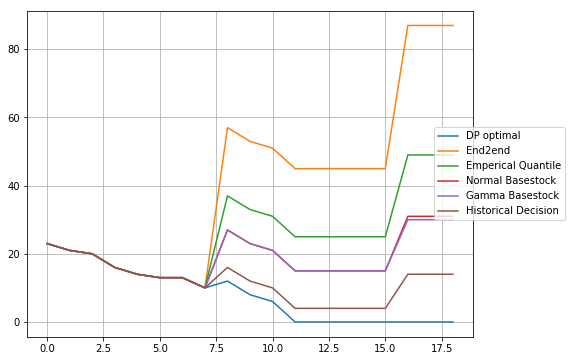

In [650]:
fig, ax1 = plt.subplots(figsize=(8, 6))
ax1.plot(inv1, label = 'DP optimal')
ax1.plot(inv3, label = 'End2end')
ax1.plot(inv2, label = 'Emperical Quantile')
ax1.plot(inv4, label = 'Normal Basestock')
ax1.plot(inv5, label = 'Gamma Basestock')
ax1.plot(inv6, label = 'Historical Decision')
ax1.legend(loc='center left', bbox_to_anchor=(0.9, 0.5))
ax1.grid()
plt.show()
# plt.savefig('fig/%i_%i.png' %(sku,dc), dpi=150)

In [651]:
df_cost.dropna(how='any', inplace=True)
df_holding.dropna(how='any', inplace=True)
df_back.dropna(how='any', inplace=True)
df_stockout.dropna(how='any', inplace=True)
df_turnover.dropna(how='any', inplace=True)
df_turnover = df_turnover[~df_turnover.isin([np.inf, -np.inf]).any(1)]
len(df_cost), len(df_holding), len(df_back), len(df_stockout), len(df_turnover)

(3293, 3293, 3293, 3293, 3286)

In [652]:
win_eq = 0
win_dp = 0
win_iid = 0
win_normal = 0
win_gamma = 0
win_hist = 0
cost_opt = []
cost_eq = []
cost_dp = []
#cost_iid = []
cost_normal = []
cost_gamma = []
cost_hist = []
TIMER = 0
# df = df_cost[df_cost['Ave_sales']>1]
df = df_cost

index_dp = []
index_eq = []
index_normal = []
index_gamma = []
index_hist = []
for i in range(len(df)):
    if((not math.isnan(df.iloc[i]['EQ'])) and (not math.isinf(df.iloc[i]['EQ']))):
        TIMER +=1
        bill = np.array([df.iloc[i]['EQ'],df.iloc[i]['End2End'],df.iloc[i]['Normal'], df.iloc[i]['Gamma'], df.iloc[i]['Hist']])
        index_min = np.argmin(bill)
        if(index_min == 0):
            win_eq +=1
            index_eq.append(i)
        elif(index_min == 1):
            win_dp+=1
            index_dp.append(i)
        elif(index_min == 2):
            win_normal+=1
            index_normal.append(i)
        elif(index_min == 3):
            win_gamma +=1
            index_gamma.append(i)
        elif(index_min == 4):
            win_hist+=1
            index_hist.append(i)
        else:
            pass
        
        if(df.iloc[i]['OPT']>=0):
            cost_opt.append(df.iloc[i]['OPT'])
        if(df.iloc[i]['EQ']>=0):
            cost_eq.append(df.iloc[i]['EQ'])
        if(df.iloc[i]['End2End']>=0):
            cost_dp.append(df.iloc[i]['End2End'])
        #cost_iid.append(df_cost.iloc[i]['End2End_iid'])
        if(df.iloc[i]['Normal']>=0):
            cost_normal.append(df.iloc[i]['Normal'])
        if(df.iloc[i]['Gamma']>=0):
            cost_gamma.append(df.iloc[i]['Gamma'])
        if(df.iloc[i]['Hist']>=0):
            cost_hist.append(df.iloc[i]['Hist'])

#cost_eq = np.sort(cost_eq)
#cost_dp = np.sort(cost_dp)
#cost_iid = np.sort(cost_iid)
#cost_normal = np.sort(cost_normal)
#cost_gamma = np.sort(cost_gamma)

print('End2End DP Win:', win_dp/TIMER, 
      'EQ Win:', win_eq/TIMER,   
      'Normal Basestock Win:', win_normal/TIMER, 
      'Gamma Basestock Win:', win_gamma/TIMER, 
      'Historical win:', win_hist/TIMER)  
print('Average order cost', 'OPT:', np.mean(cost_opt), 
      'End2End DP:', np.mean(cost_dp), 
      'EQ:', np.mean(cost_eq), 
      'Normal Basestock:', np.mean(cost_normal), 
      'Gamma:', np.mean(cost_gamma),
      'Historical Decision:', np.mean(cost_hist))

End2End DP Win: 0.19374430610385668 EQ Win: 0.12116610993015488 Normal Basestock Win: 0.128150622532645 Gamma Basestock Win: 0.24688733677497723 Historical win: 0.3100516246583662
Average order cost OPT: 4742.3504403279685 End2End DP: 29779.86668691163 EQ: 21631.83905253568 Normal Basestock: 15645.762526571516 Gamma: 15390.81992104464 Historical Decision: 28466.166717279077


In [653]:
pd.DataFrame({'Total': df_cost[['OPT','End2End','EQ','Normal','Gamma','Hist','Ave_sales']].mean(),
             'Holding': df_holding[['OPT','End2End','EQ','Normal','Gamma','Hist','Ave_sales']].mean(),
             'Back': df_back[['OPT','End2End','EQ','Normal','Gamma','Hist','Ave_sales']].mean(),
             'Stockout': df_stockout[['OPT','End2End','EQ','Normal','Gamma','Hist','Ave_sales']].mean(),
             'Turnover': df_turnover[['OPT','End2End','EQ','Normal','Gamma','Hist','Ave_sales']].mean(),
             }).T

,OPT,End2End,EQ,Normal,Gamma,Hist,Ave_sales
Total,4742.350440,29779.866687,21631.839053,15645.762527,15390.819921,28466.166717,15.626071
Holding,3599.172791,11870.793198,19813.680534,13405.041300,13045.230793,1119.014880,15.626071
Back,1143.177650,17909.073489,1818.158518,2240.721227,2345.589128,27347.151837,15.626071
Stockout,0.235262,0.114725,0.114389,0.130197,0.132931,0.523421,15.626071
Turnover,7.622364,31.585013,45.808492,31.246095,30.855819,4.215437,15.659087


In [654]:
df_cost.sort_values('Normal')

,SKU_DC,OPT,End2End,EQ,Normal,Gamma,Hist,Ave_sales,Std_sales
3241,7227784#4,1,13,9,5,5,19,0.131687,0.452637
524,1303986#9,0,30,9,9,9,30,0.148148,0.438228
2510,5231292#9,3,31,7,11,9,17,0.407407,1.89288
2308,4847412#4,0,42,6,12,12,60,0.0658436,0.448805
476,1302737#4,1,25,16,13,13,28,0.1893,0.670643
3224,7125593#6,7,105,35,14,14,77,0.205761,0.535612
1918,4410276#5,0,24,21,18,18,30,0.304527,0.915044
478,1302737#9,2,26,46,18,18,38,0.263374,0.682359
1738,4181037#316,0,190,38,19,19,190,0.0246914,0.179756
1501,3687223#5,19,43,19,19,19,39,0.222222,0.587945


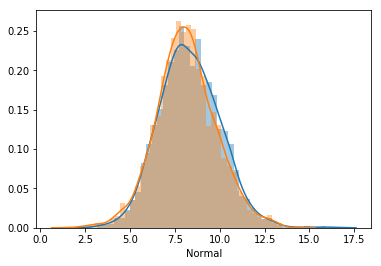

In [655]:
sns.distplot(np.log(df_cost['End2End'].astype(float)));
sns.distplot(np.log(df_cost['Normal'].astype(float)));
# sns.distplot(df_cost['End2End'].astype(float), bins=20, kde=False);
# sns.distplot(df_cost['Normal'].astype(float), bins=20, kde=False);

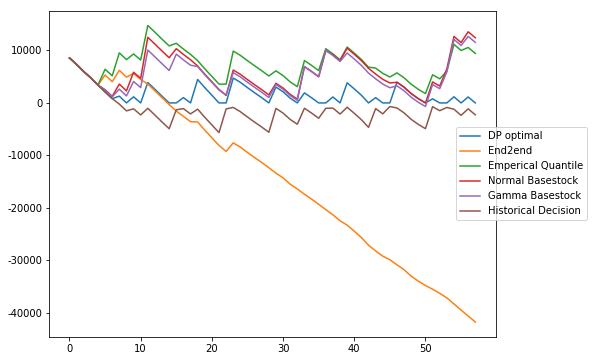

In [647]:
sku_dc = '4803348#10'
#     #############get parameter for specific pair of sku, dc
df = o1[o1.item_sku_id == sku_dc]

ref_time = START_DAY_HIST+START_DAY
order_time = df['create_tm_index'].tolist()
order_time = [time-ref_time for time in order_time] 
arrive_time = df['complete_dt_index'].tolist()
arrive_time = [time-ref_time for time in arrive_time]

demand = df_sales[df_sales.row == sku_dc].values[0]
#     stk = df_stocks[(df_stocks.sku_id == sku) & (df_stocks.int_org_num == dc)].values[0]

if(len(demand)==0):
    t = t+1
else:
    demand = demand[START_DAY_HIST + 1:] 

    inv0 = np.array(df['initial_stock'])[0]

    h = 1
    b = 9

    '''----------------------------------- OPTION 0: DP optimal ----------------------------'''
    inv1, c1, b1, h1 = seqtest(sku_dc, START_DAY, inv0, df, gbm_dq, end_of_horizon, arrive_time, order_time, demand, feature_list, OPTION=0)

    '''----------------------------------- OPTION 1: Emperical Quantile ----------------------------'''
    inv2, c2, b2, h2 = seqtest(sku_dc, START_DAY, inv0, df, gbm_dq, end_of_horizon, arrive_time, order_time, demand, feature_list, OPTION=1)

    '''----------------------------------- OPTION 2: End2End DP ----------------------------'''
    inv3, c3, b3, h3 = seqtest(sku_dc, START_DAY, inv0, df, gbm_dq, end_of_horizon, arrive_time, order_time, demand, feature_list, OPTION=2)

    '''----------------------------------- OPTION 3: End2End i.i.d. ----------------------------'''
    '''inv4, c4, b4, h4 = seqtest(sku, dc, START_DAY, inv0, df, gbm_dq, gbm_iid, end_of_horizon, arrive_time, order_time, demand, feature, OPTION=3)
    df_cost.loc[i]['End2End_iid'] = c4'''

    '''----------------------------------- OPTION 3: Normal Basestock ----------------------------'''
    inv4, c4, b4, h4 = seqtest(sku_dc, START_DAY, inv0, df, gbm_dq, end_of_horizon, arrive_time, order_time, demand, feature_list, OPTION=3)

    '''----------------------------------- OPTION Gamma Normal Basestock ----------------------------'''
    inv5, c5, b5, h5 = seqtest(sku_dc, START_DAY, inv0, df, gbm_dq, end_of_horizon, arrive_time, order_time, demand, feature_list, OPTION=4)

    '''----------------------------------- OPTION 5: Historical Decision ----------------------------'''
    inv6, c6, b6, h6 = seqtest(sku_dc, START_DAY, inv0, df, gbm_dq, end_of_horizon, arrive_time, order_time, demand, feature_list, OPTION=5)

    fig, ax1 = plt.subplots(figsize=(8, 6))
    ax1.plot(inv1, label = 'DP optimal')
    ax1.plot(inv3, label = 'End2end')
    ax1.plot(inv2, label = 'Emperical Quantile')
    ax1.plot(inv4, label = 'Normal Basestock')
    ax1.plot(inv5, label = 'Gamma Basestock')
    ax1.plot(inv6, label = 'Historical Decision')
    ax1.legend(loc='center left', bbox_to_anchor=(0.9, 0.5))